<h1>3. Exploratory Data Analysis</h1>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
import nltk
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

/home/vishal/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


<h2>3.1. Reading Data</h2>

<h3>3.1.1. Reading Gene and Variation Data</h3>

In [2]:
result=pd.read_csv('./cancer.csv')

In [2]:
data = pd.read_csv('training_variants')
print('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])
print('Features : ', data.columns.values)
data.head()

Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


<h3>3.1.2. Reading Text Data</h3>

In [3]:
data_text =pd.read_csv("training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
print('Number of data points : ', data_text.shape[0])
print('Number of features : ', data_text.shape[1])
print('Features : ', data_text.columns.values)
data_text.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


<h3>3.1.3. Preprocessing of text</h3>

In [4]:
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d stpwords
    Error loading stpwords: Package 'stpwords' not found in index

---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d stopwords
      Unzipping corpora/stopwords.zip.

---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


True

In [5]:
from nltk.corpus import stopwords

# loading stop words from nltk library
stop_words = set(stopwords.words('english'))

def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        data_text[column][index] = string

In [6]:
stop_words.remove('not')

In [7]:
start_time = time.clock()
for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        nlp_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("there is no text description for id:",index)
print('Time took for preprocessing the text :',time.clock() - start_time, "seconds")

there is no text description for id: 1109
there is no text description for id: 1277
there is no text description for id: 1407
there is no text description for id: 1639
there is no text description for id: 2755
Time took for preprocessing the text : 156.91617 seconds


In [8]:
#merging both gene_variations and text data based on ID
result = pd.merge(data, data_text,on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [9]:
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] +' '+result['Variation']

In [11]:
result.to_csv('./cancer.csv', columns=result.columns, index=False)

<h3>3.1.4. Test, Train and Cross Validation Split</h3>

<h4>3.1.4.1. Splitting data into train, test and cross validation (64:20:16)</h4>

In [3]:
y_true = result['Class'].values
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [4]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

In [5]:
def get_gv_fea_dict(alpha, feature, df):
    value_count = train_df[feature].value_counts()
    
    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gv_dict = dict()
    
    # denominator will contain the number of time that particular feature occured in whole data
    for i, denominator in value_count.items():
        # vec will contain (p(yi==1/Gi) probability of gene/variation belongs to perticular class
        # vec is 9 diamensional vector
        vec = []
        for k in range(1,10):
            # print(train_df.loc[(train_df['Class']==1) & (train_df['Gene']=='BRCA1')])
            #         ID   Gene             Variation  Class  
            # 2470  2470  BRCA1                S1715C      1   
            # 2486  2486  BRCA1                S1841R      1   
            # 2614  2614  BRCA1                   M1R      1   
            # 2432  2432  BRCA1                L1657P      1   
            # 2567  2567  BRCA1                T1685A      1   
            # 2583  2583  BRCA1                E1660G      1   
            # 2634  2634  BRCA1                W1718L      1   
            # cls_cnt.shape[0] will return the number of rows

            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            
            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        # we are adding the gene/variation to the dict as key and vec as value
        gv_dict[i]=vec
    return gv_dict

def get_gv_feature(alpha, feature, df):
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    # value_count is similar in get_gv_fea_dict
    value_count = train_df[feature].value_counts()
    
    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    # for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to gv_fea
    # if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
#             gv_fea.append([-1,-1,-1,-1,-1,-1,-1,-1,-1])
    return gv_fea

## Gene featurisation
### Response coding

In [6]:
#response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))
# test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))
# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))

## one-hot encoding of Gene feature.

In [6]:
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

## Variation featurisation
### Response coding

In [7]:
alpha = 1
# train gene feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))
# test gene feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))
# cross validation gene feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))

## one-hot encoding of variation feature.

In [7]:
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

## Text featurisation

In [8]:
def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [9]:
import math
#https://stackoverflow.com/a/1602964
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index=0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log((dict_list[i].get(word,0)+10)/(len(y_train[y_train==i])+90))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index+=1
    return text_feature_responseCoding

In [14]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 53458


## Tfidf vectorisation of text

In [8]:
text_vectorizer_tfidf = TfidfVectorizer(min_df=3)
train_text_feature_tfidf = text_vectorizer_tfidf.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
train_text_features_tfidf= text_vectorizer_tfidf.get_feature_names()

print("Total number of unique words in train data :", len(train_text_features_tfidf))

Total number of unique words in train data : 52331


In [10]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))

In [11]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

In [12]:
# https://stackoverflow.com/a/16202486
# we convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [27]:
# don't forget to normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=1)

# we use the same vectorizer that was trained on train data
test_text_feature = text_vectorizer.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=1)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=1)

In [8]:
train_text_feature_tfidf = normalize(train_text_feature_tfidf, axis=1)

# we use the same vectorizer that was trained on train data
test_text_feature_tfidf = text_vectorizer_tfidf.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_tfidf = normalize(test_text_feature_tfidf, axis=1)

# we use the same vectorizer that was trained on train data
cv_text_feature_tfidf = text_vectorizer_tfidf.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_tfidf = normalize(cv_text_feature_tfidf, axis=1)

## Machine learning models

In [13]:
def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)
    
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_count_vec.fit(train_df['Gene'])
    var_count_vec.fit(train_df['Variation'])
    text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_count_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_count_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_count_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_count_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

<p style="font-size:24px;text-align:Center"> <b>Stacking the three types of features </b><p>

In [19]:
train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding, train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding, test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding, cv_variation_feature_onehotCoding))

NameError: name 'train_gene_feature_onehotCoding' is not defined

In [14]:
train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))


In [16]:
train_x_onehotCoding_tfidf = hstack((train_gene_var_onehotCoding, train_text_feature_tfidf)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding_tfidf = hstack((test_gene_var_onehotCoding, test_text_feature_tfidf)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding_tfidf = hstack((cv_gene_var_onehotCoding, cv_text_feature_tfidf)).tocsr()
cv_y = np.array(list(cv_df['Class']))

# Naive bayes

for alpha = 1e-05
Log Loss : 1.2394860285617766
for alpha = 0.0001
Log Loss : 1.2420254086208948
for alpha = 0.001
Log Loss : 1.23712912077745
for alpha = 0.01
Log Loss : 1.2120048627867488
for alpha = 0.1
Log Loss : 1.213092992468053
for alpha = 1
Log Loss : 1.2501613923579606
for alpha = 10
Log Loss : 1.2336381372204075
for alpha = 100
Log Loss : 1.270198465841236
for alpha = 1000
Log Loss : 1.2790579547775802


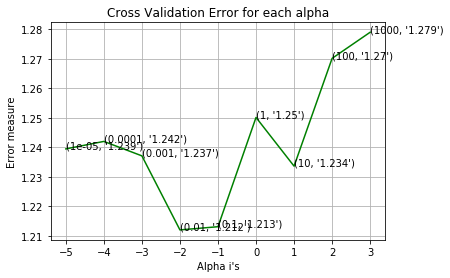

For values of best alpha =  0.01 The train log loss is: 0.6743274374989594
For values of best alpha =  0.01 The cross validation log loss is: 1.2120048627867488
For values of best alpha =  0.01 The test log loss is: 1.1615639771335267


In [30]:
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding_tfidf, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding_tfidf, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding_tfidf)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs, eps=1e-15)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding_tfidf, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


Log Loss : 1.2120048627867488
Number of missclassified point : 0.38721804511278196
-------------------- Confusion matrix --------------------


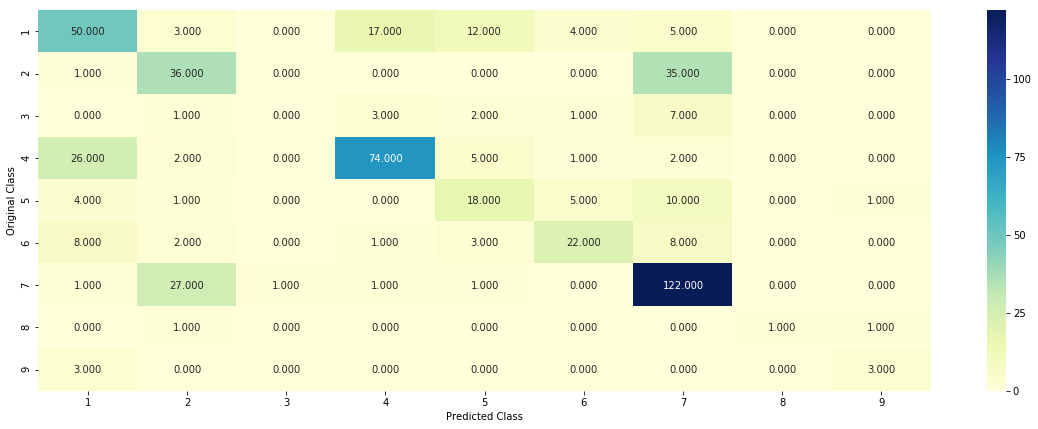

-------------------- Precision matrix (Columm Sum=1) --------------------


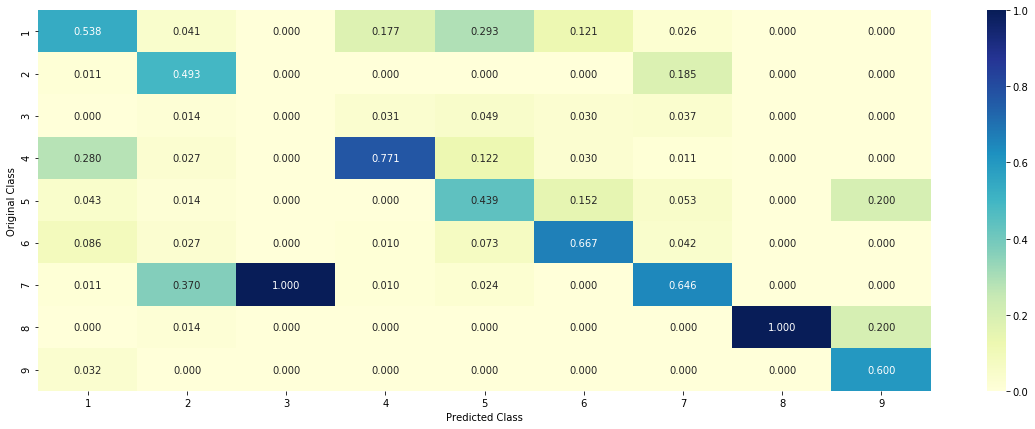

-------------------- Recall matrix (Row sum=1) --------------------


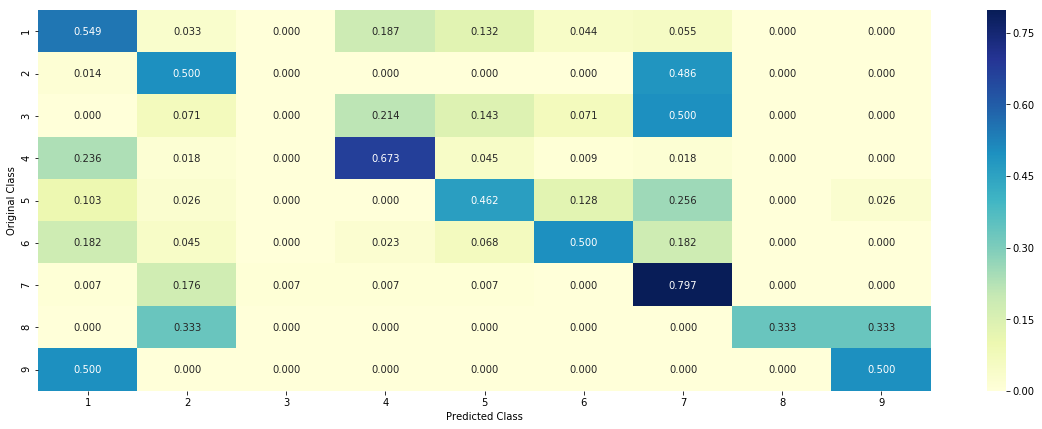

In [31]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding_tfidf, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding_tfidf)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding_tfidf)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding_tfidf))

<h4>4.1.1.4. Feature Importance, correctly classified point</h4>

In [32]:
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding_tfidf[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding_tfidf[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0683 0.1255 0.0165 0.0871 0.0404 0.0376 0.6175 0.0047 0.0024]]
Actual Class : 7
--------------------------------------------------
1 Text feature [mutations] present in test data point [True]
2 Text feature [cells] present in test data point [True]
8 Text feature [cell] present in test data point [True]
9 Text feature [fig] present in test data point [True]
11 Text feature [kinase] present in test data point [True]
15 Text feature [al] present in test data point [True]
16 Text feature [et] present in test data point [True]
17 Text feature [ras] present in test data point [True]
19 Text feature [figure] present in test data point [True]
29 Text feature [not] present in test data point [True]
30 Text feature [cancer] present in test data point [True]
32 Text feature [mutant] present in test data point [True]
33 Text feature [kit] present in test data point [True]
35 Text feature [tumor] present in test data point [True]
37 Text featu

<h4>4.1.1.4. Feature Importance, Incorrectly classified point</h4>

In [35]:
test_point_index = 30
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding_tfidf[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding_tfidf[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[0.0941 0.4881 0.0224 0.1921 0.0464 0.043  0.1056 0.0053 0.0029]]
Actual Class : 4
--------------------------------------------------
2 Text feature [mutations] present in test data point [True]
8 Text feature [patients] present in test data point [True]
11 Text feature [mutation] present in test data point [True]
14 Text feature [kit] present in test data point [True]
22 Text feature [exon] present in test data point [True]
24 Text feature [not] present in test data point [True]
25 Text feature [figure] present in test data point [True]
42 Text feature [treatment] present in test data point [True]
44 Text feature [gene] present in test data point [True]
45 Text feature [clinical] present in test data point [True]
47 Text feature [response] present in test data point [True]
50 Text feature [using] present in test data point [True]
51 Text feature [analysis] present in test data point [True]
57 Text feature [10] present in test data po

<h2>4.2. K Nearest Neighbour Classification</h2>

<h3>4.2.1. Hyper parameter tuning</h3>

for alpha = 5
Log Loss : 1.0300632742024318
for alpha = 11
Log Loss : 1.012643657712813
for alpha = 15
Log Loss : 1.0073507032538163
for alpha = 21
Log Loss : 1.0256545392238312
for alpha = 31
Log Loss : 1.048322310123663
for alpha = 41
Log Loss : 1.074360112714669
for alpha = 51
Log Loss : 1.0868991377325987
for alpha = 99
Log Loss : 1.1049551551872598


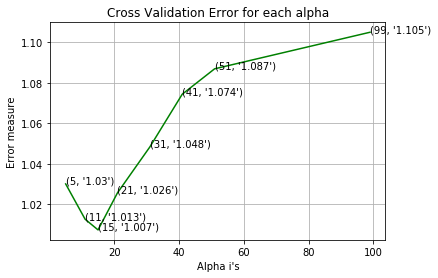

For values of best alpha =  15 The train log loss is: 0.7330734772470927
For values of best alpha =  15 The cross validation log loss is: 1.0073507032538163
For values of best alpha =  15 The test log loss is: 1.0877486660210434


In [36]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


Log loss : 1.0073507032538163
Number of mis-classified points : 0.34398496240601506
-------------------- Confusion matrix --------------------


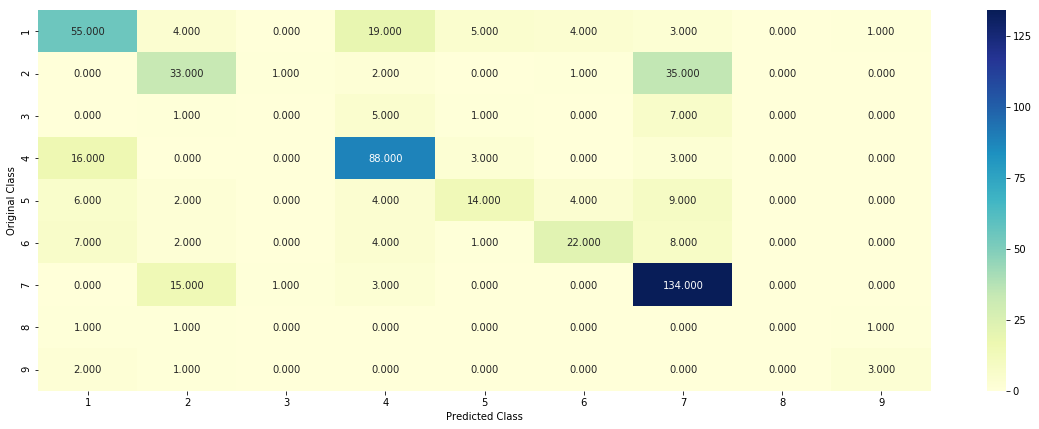

-------------------- Precision matrix (Columm Sum=1) --------------------


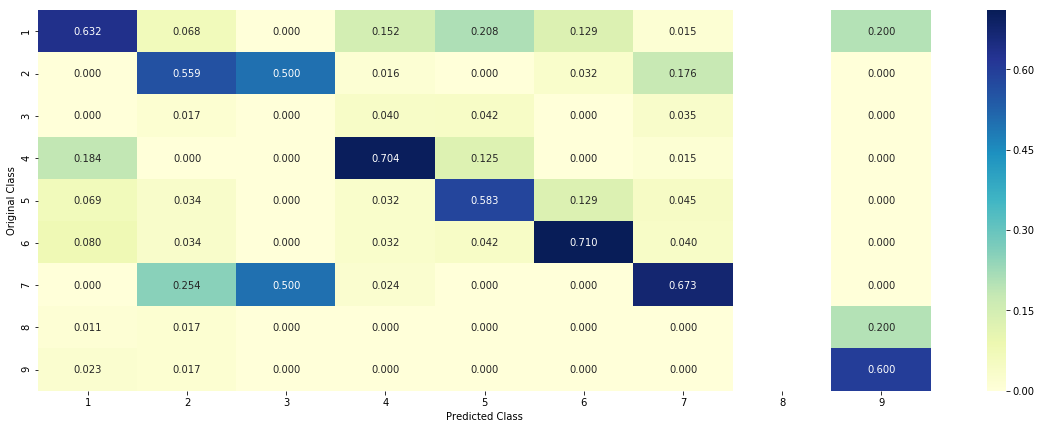

-------------------- Recall matrix (Row sum=1) --------------------


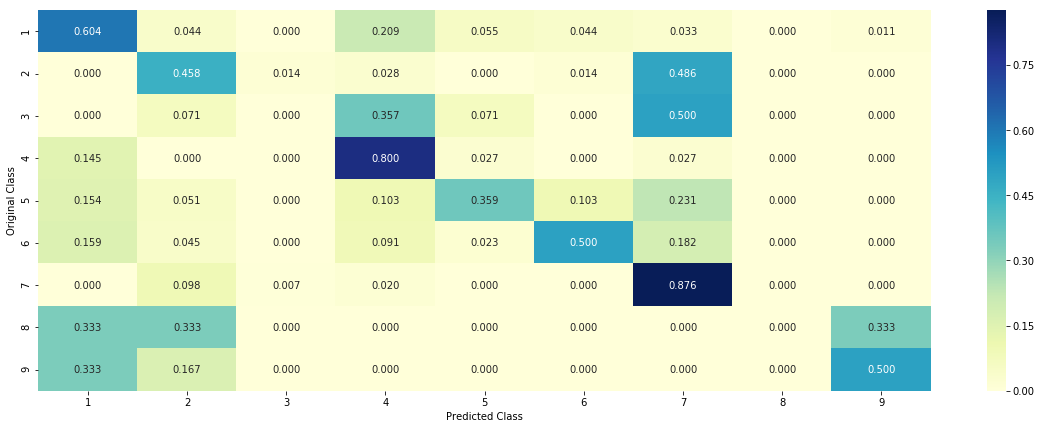

In [37]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

In [38]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 1
predicted_cls = sig_clf.predict(test_x_responseCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 4
Actual Class : 7
The  15  nearest neighbours of the test points belongs to classes [7 7 2 2 7 7 7 6 2 7 7 2 6 7 2]
Fequency of nearest points : Counter({7: 8, 2: 5, 6: 2})


In [39]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 100

predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("the k value for knn is",alpha[best_alpha],"and the nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 1
Actual Class : 1
the k value for knn is 15 and the nearest neighbours of the test points belongs to classes [1 1 6 1 1 1 1 1 1 1 1 1 1 1 1]
Fequency of nearest points : Counter({1: 14, 6: 1})


<h2>4.3. Logistic Regression</h2>

<h3>4.3.1. With Class balancing</h3>

<h4>4.3.1.1. Hyper paramter tuning</h4>

for alpha = 1e-06
Log Loss : 1.1829513532350984
for alpha = 1e-05
Log Loss : 1.0841643159484966
for alpha = 0.0001
Log Loss : 0.9775128360306393
for alpha = 0.001
Log Loss : 1.0156088817062647
for alpha = 0.01
Log Loss : 1.1882381139406921
for alpha = 0.1
Log Loss : 1.4122538735433008
for alpha = 1
Log Loss : 1.4906591473978101
for alpha = 10
Log Loss : 1.5017503835913875
for alpha = 100
Log Loss : 1.503068266768409


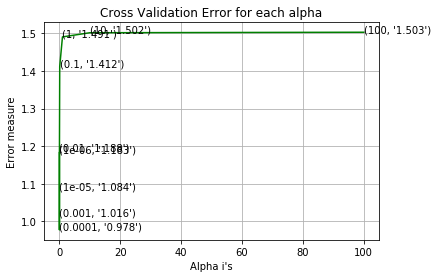

For values of best alpha =  0.0001 The train log loss is: 0.40850487630139704
For values of best alpha =  0.0001 The cross validation log loss is: 0.9775128360306393
For values of best alpha =  0.0001 The test log loss is: 0.966259235546475


In [40]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding_tfidf, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding_tfidf, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding_tfidf)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding_tfidf, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 0.9775128360306393
Number of mis-classified points : 0.35526315789473684
-------------------- Confusion matrix --------------------


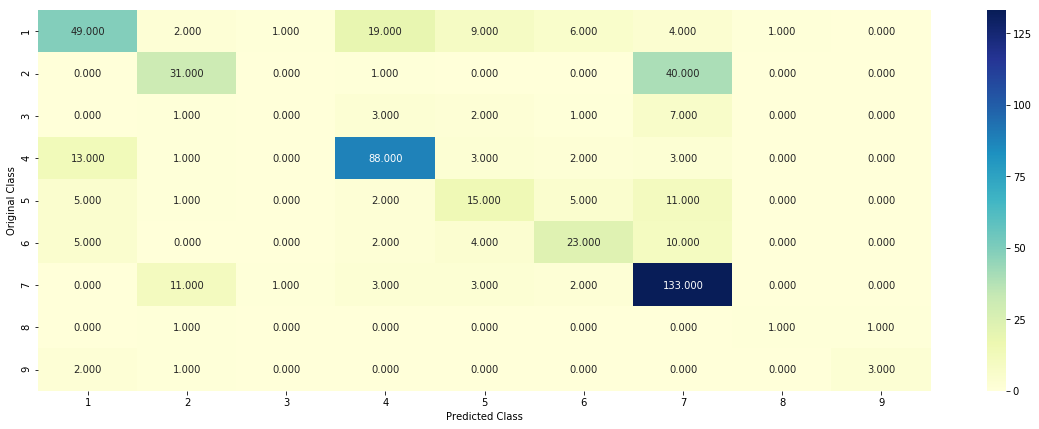

-------------------- Precision matrix (Columm Sum=1) --------------------


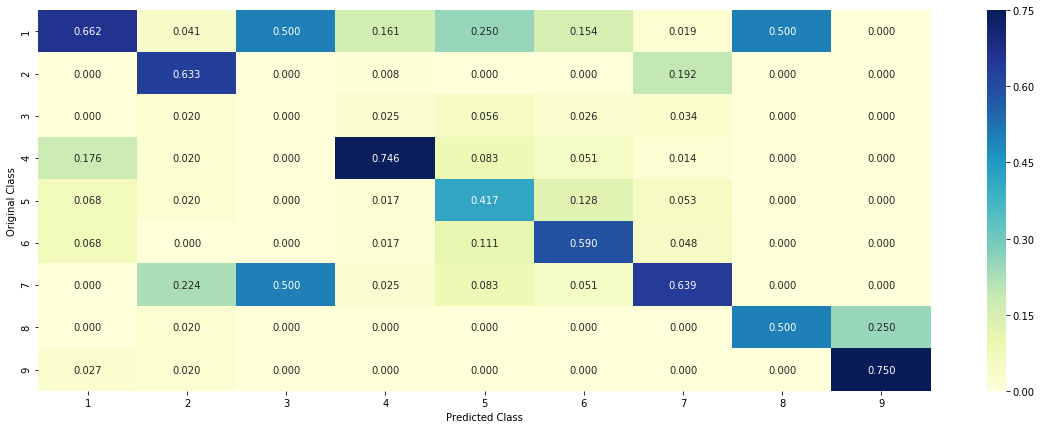

-------------------- Recall matrix (Row sum=1) --------------------


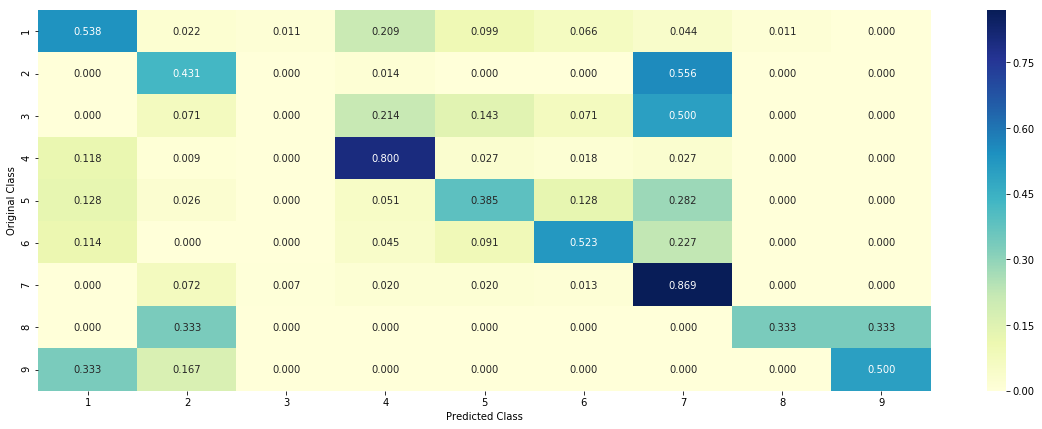

In [41]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding_tfidf, train_y, cv_x_onehotCoding_tfidf, cv_y, clf)

<h4>4.3.1.3. Feature Importance</h4>`

<h5>4.3.1.3.1. Correctly Classified point</h5>

In [44]:
# from tabulate import tabulate
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding_tfidf,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding_tfidf[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding_tfidf[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0162 0.2978 0.0167 0.035  0.0195 0.0754 0.5336 0.0031 0.0028]]
Actual Class : 7
--------------------------------------------------
5 Text feature [cells] present in test data point [True]
10 Text feature [fig] present in test data point [True]
39 Text feature [activation] present in test data point [True]
59 Text feature [ras] present in test data point [True]
139 Text feature [expressing] present in test data point [True]
229 Text feature [cyclin] present in test data point [True]
239 Text feature [mice] present in test data point [True]
259 Text feature [domain] present in test data point [True]
283 Text feature [pathway] present in test data point [True]
315 Text feature [mutants] present in test data point [True]
345 Text feature [growth] present in test data point [True]
359 Text feature [kinase] present in test data point [True]
373 Text feature [codon] present in test data point [True]
378 Text feature [gtp] present in test 

<h5>4.3.1.3.2. Incorrectly Classified point</h5>

In [47]:
test_point_index = 20
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding_tfidf[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding_tfidf[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.5802 0.0403 0.0245 0.0578 0.2074 0.0298 0.0462 0.0078 0.0061]]
Actual Class : 6
--------------------------------------------------
265 Text feature [hotspot] present in test data point [True]
338 Text feature [merlin] present in test data point [True]
350 Text feature [structure] present in test data point [True]
363 Text feature [nf2] present in test data point [True]
414 Text feature [binding] present in test data point [True]
425 Text feature [region] present in test data point [True]
450 Text feature [variations] present in test data point [True]
460 Text feature [function] present in test data point [True]
480 Text feature [kda] present in test data point [True]
Out of the top  500  features  9 are present in query point


<h3>4.3.2. Without Class balancing</h3>

<h4>4.3.2.1. Hyper paramter tuning</h4>

for alpha = 1e-06
Log Loss : 1.1402529587053032
for alpha = 1e-05
Log Loss : 1.080087080357061
for alpha = 0.0001
Log Loss : 0.9684682182487381
for alpha = 0.001
Log Loss : 1.0114340273189524
for alpha = 0.01
Log Loss : 1.1667590345369185
for alpha = 0.1
Log Loss : 1.347140229142684
for alpha = 1
Log Loss : 1.4279222899903956
for alpha = 10
Log Loss : 1.4395969718144255
for alpha = 100
Log Loss : 1.4410158982105883


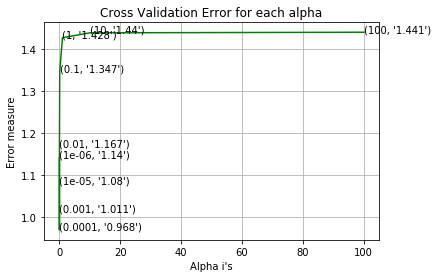

For values of best alpha =  0.0001 The train log loss is: 0.3987956862011045
For values of best alpha =  0.0001 The cross validation log loss is: 0.9684682182487381
For values of best alpha =  0.0001 The test log loss is: 0.9662565726380687


In [48]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding_tfidf, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding_tfidf, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding_tfidf)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding_tfidf, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

<h4>4.3.2.2. Testing model with best hyper parameters</h4>

Log loss : 0.9684682182487381
Number of mis-classified points : 0.3533834586466165
-------------------- Confusion matrix --------------------


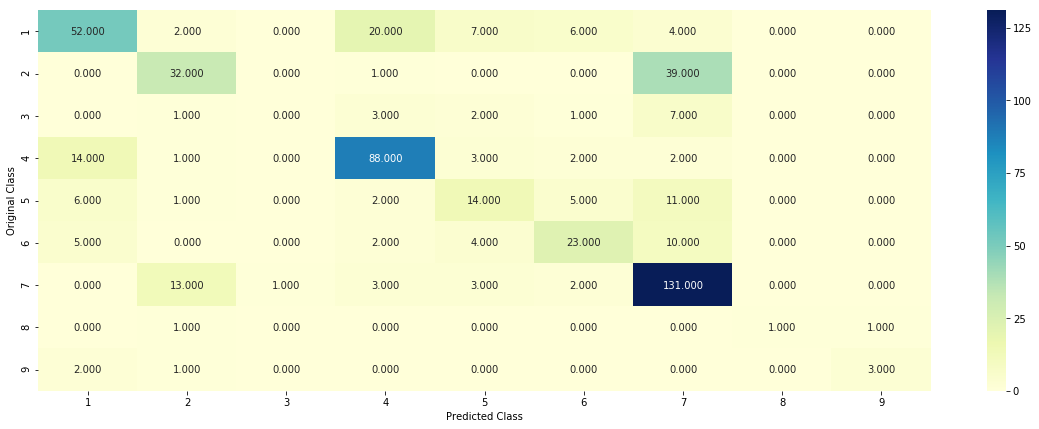

-------------------- Precision matrix (Columm Sum=1) --------------------


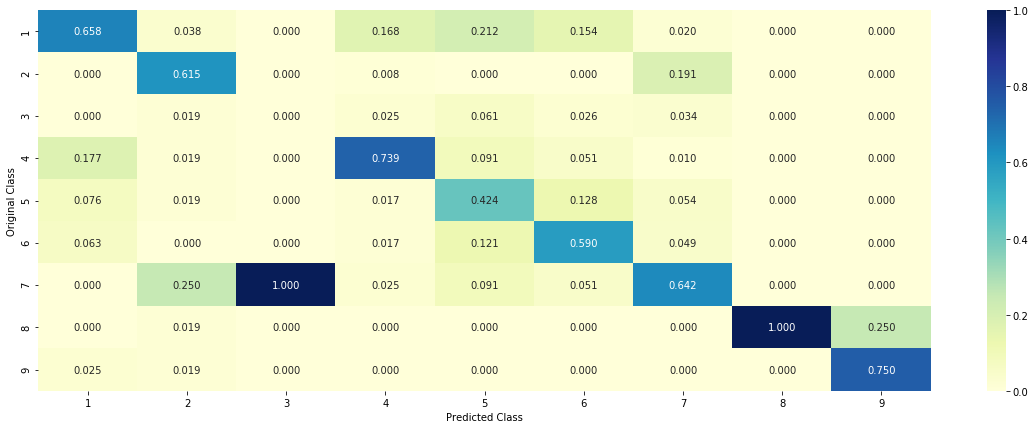

-------------------- Recall matrix (Row sum=1) --------------------


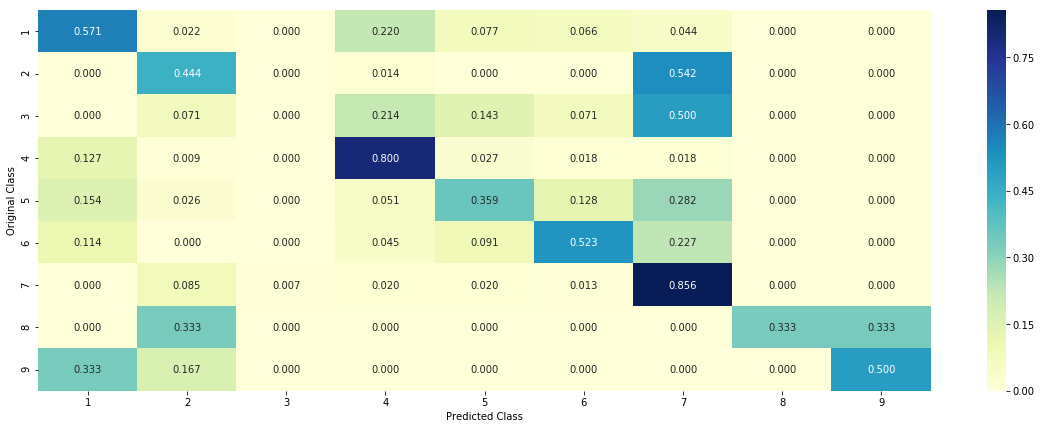

In [49]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding_tfidf, train_y, cv_x_onehotCoding_tfidf, cv_y, clf)

<h4>4.3.2.3. Feature Importance, Correctly Classified point</h4>

In [50]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding_tfidf,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding_tfidf[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding_tfidf[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0141 0.2981 0.0102 0.032  0.0209 0.0824 0.5312 0.0071 0.0039]]
Actual Class : 7
--------------------------------------------------
9 Text feature [cells] present in test data point [True]
15 Text feature [fig] present in test data point [True]
68 Text feature [activation] present in test data point [True]
128 Text feature [ras] present in test data point [True]
182 Text feature [expressing] present in test data point [True]
233 Text feature [domain] present in test data point [True]
269 Text feature [mutants] present in test data point [True]
305 Text feature [pathway] present in test data point [True]
306 Text feature [cyclin] present in test data point [True]
322 Text feature [mice] present in test data point [True]
385 Text feature [growth] present in test data point [True]
395 Text feature [cancers] present in test data point [True]
412 Text feature [codon] present in test data point [True]
457 Text feature [promoter] present i

<h4>4.3.2.4. Feature Importance, Inorrectly Classified point</h4>

In [52]:
test_point_index = 30
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding_tfidf[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding_tfidf[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[0.153  0.3636 0.0725 0.2272 0.0445 0.0355 0.0717 0.0165 0.0156]]
Actual Class : 4
--------------------------------------------------
34 Text feature [patients] present in test data point [True]
206 Text feature [clinical] present in test data point [True]
228 Text feature [response] present in test data point [True]
253 Text feature [gata3] present in test data point [True]
324 Text feature [rate] present in test data point [True]
421 Text feature [gene] present in test data point [True]
439 Text feature [mutations] present in test data point [True]
446 Text feature [gata] present in test data point [True]
449 Text feature [primary] present in test data point [True]
453 Text feature [2014] present in test data point [True]
455 Text feature [treatment] present in test data point [True]
Out of the top  500  features  11 are present in query point


<h2>4.4. Linear Support Vector Machines</h2>
<h3>4.4.1. Hyper paramter tuning</h3>

for C = 1e-05
Log Loss : 1.1402328335862197
for C = 0.0001
Log Loss : 1.0900087004561814
for C = 0.001
Log Loss : 1.0772148694828203
for C = 0.01
Log Loss : 1.257884001433885
for C = 0.1
Log Loss : 1.4499054628809491
for C = 1
Log Loss : 1.5033775715472097
for C = 10
Log Loss : 1.5034234122122958
for C = 100
Log Loss : 1.5034234147308854


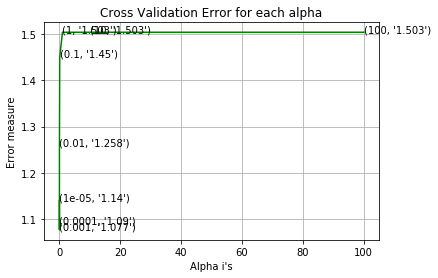

For values of best alpha =  0.001 The train log loss is: 0.5500427314696233
For values of best alpha =  0.001 The cross validation log loss is: 1.0772148694828203
For values of best alpha =  0.001 The test log loss is: 1.0772326536191437


In [53]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding_tfidf, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding_tfidf, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding_tfidf)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding_tfidf, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

<h3>4.4.2. Testing model with best hyper parameters</h3>

Log loss : 1.0772148694828203
Number of mis-classified points : 0.35902255639097747
-------------------- Confusion matrix --------------------


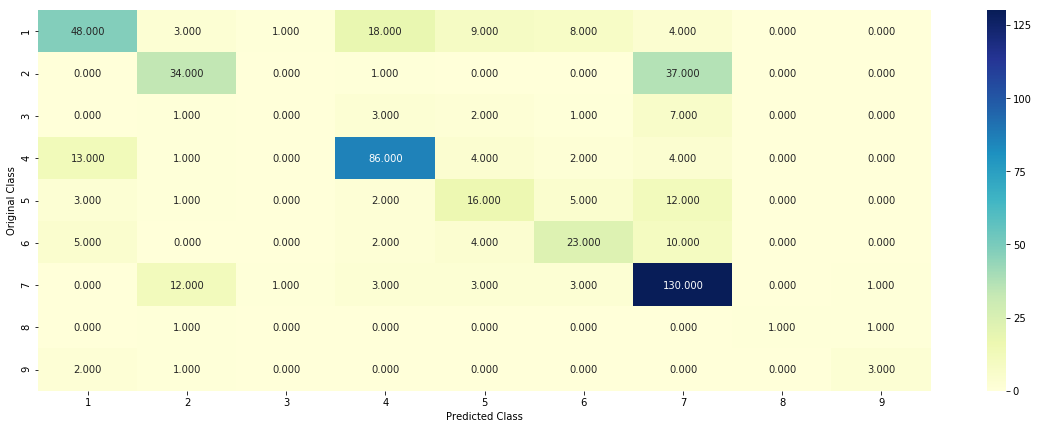

-------------------- Precision matrix (Columm Sum=1) --------------------


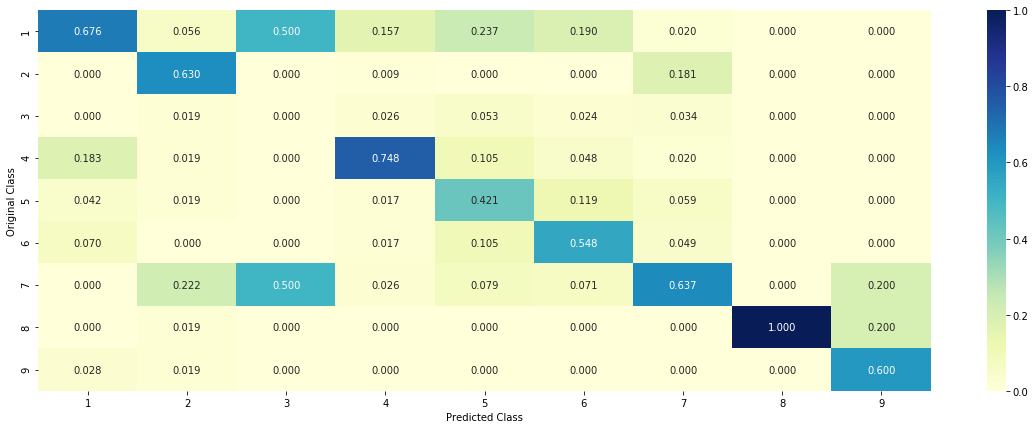

-------------------- Recall matrix (Row sum=1) --------------------


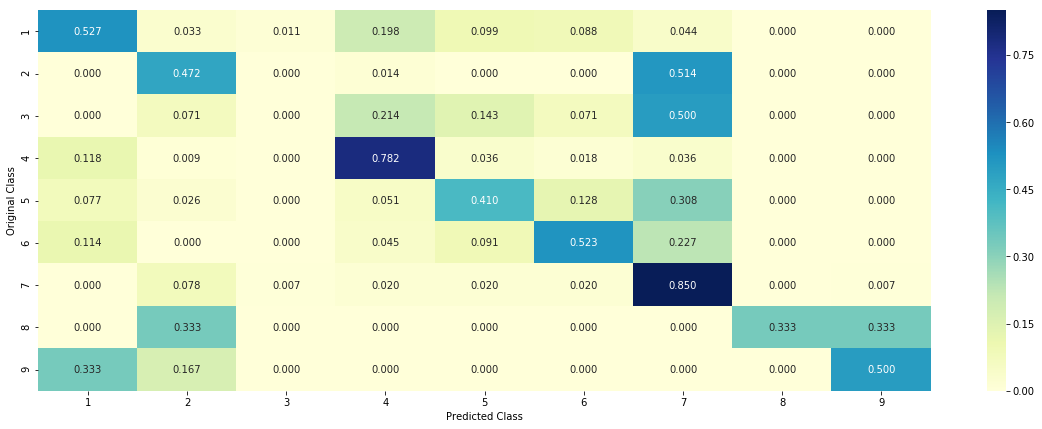

In [54]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(train_x_onehotCoding_tfidf, train_y,cv_x_onehotCoding_tfidf,cv_y, clf)

<h3>4.3.3. Feature Importance</h3>

<h4>4.3.3.1. For Correctly classified point</h4>

In [55]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding_tfidf,train_y)
test_point_index = 1
# test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding_tfidf[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding_tfidf[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0407 0.2014 0.019  0.0664 0.0412 0.0666 0.557  0.0044 0.0033]]
Actual Class : 7
--------------------------------------------------
1 Text feature [cells] present in test data point [True]
6 Text feature [fig] present in test data point [True]
21 Text feature [activation] present in test data point [True]
36 Text feature [domain] present in test data point [True]
46 Text feature [mutants] present in test data point [True]
66 Text feature [expressing] present in test data point [True]
74 Text feature [mice] present in test data point [True]
210 Text feature [ras] present in test data point [True]
212 Text feature [signaling] present in test data point [True]
220 Text feature [cyclin] present in test data point [True]
225 Text feature [cell] present in test data point [True]
235 Text feature [codon] present in test data point [True]
239 Text feature [mutant] present in test data point [True]
398 Text feature [pathway] present in test 

<h4>4.3.3.2. For Incorrectly classified point</h4>

In [56]:
test_point_index = 30
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding_tfidf[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding_tfidf[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[0.1334 0.4114 0.0463 0.235  0.0326 0.0243 0.1049 0.0071 0.0049]]
Actual Class : 4
--------------------------------------------------
5 Text feature [patients] present in test data point [True]
27 Text feature [mutations] present in test data point [True]
223 Text feature [clinical] present in test data point [True]
272 Text feature [gata3] present in test data point [True]
282 Text feature [response] present in test data point [True]
366 Text feature [rate] present in test data point [True]
372 Text feature [gata] present in test data point [True]
381 Text feature [primary] present in test data point [True]
424 Text feature [2014] present in test data point [True]
449 Text feature [height] present in test data point [True]
473 Text feature [treatment] present in test data point [True]
489 Text feature [kg] present in test data point [True]
495 Text feature [sequencing] present in test data point [True]
496 Text feature [15] present i

<h2>4.5 Random Forest Classifier</h2>
<h3>4.5.1. Hyper paramter tuning (With TF IDF)</h3>

In [21]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding_tfidf, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding_tfidf, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding_tfidf)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15)) 

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding_tfidf, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding_tfidf)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding_tfidf)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding_tfidf)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 100 and max depth =  5
Log Loss : 1.2174116159443373
for n_estimators = 100 and max depth =  10
Log Loss : 1.119515123590549
for n_estimators = 200 and max depth =  5
Log Loss : 1.2009054301841338
for n_estimators = 200 and max depth =  10
Log Loss : 1.1102571302101505
for n_estimators = 500 and max depth =  5
Log Loss : 1.1906476346283819
for n_estimators = 500 and max depth =  10
Log Loss : 1.1095074788838821
for n_estimators = 1000 and max depth =  5
Log Loss : 1.1891689204897424
for n_estimators = 1000 and max depth =  10
Log Loss : 1.1079130205562244
for n_estimators = 2000 and max depth =  5
Log Loss : 1.1857088919411356
for n_estimators = 2000 and max depth =  10
Log Loss : 1.106144812988379
For values of best estimator =  2000 The train log loss is: 0.6479691577511337
For values of best estimator =  2000 The cross validation log loss is: 1.106144812988379
For values of best estimator =  2000 The test log loss is: 1.0597665031789139


Log loss : 1.0833657777124572
Number of mis-classified points : 0.37781954887218044
-------------------- Confusion matrix --------------------


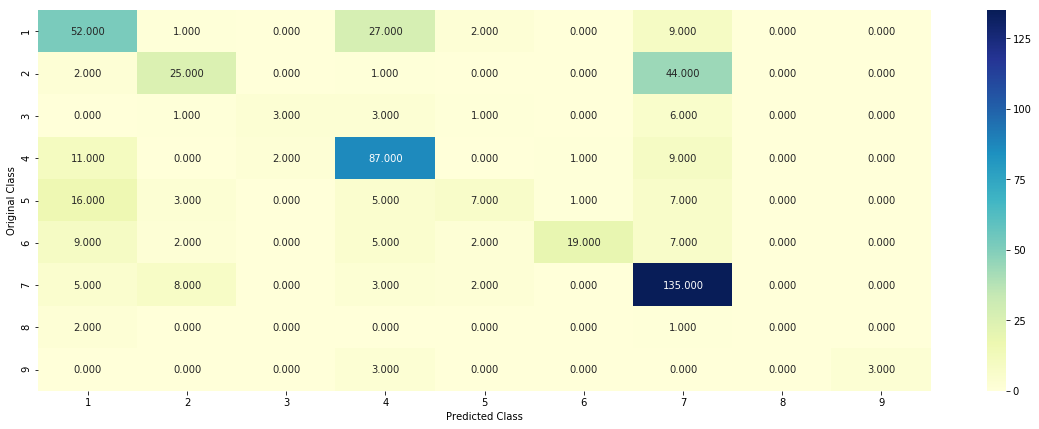

-------------------- Precision matrix (Columm Sum=1) --------------------


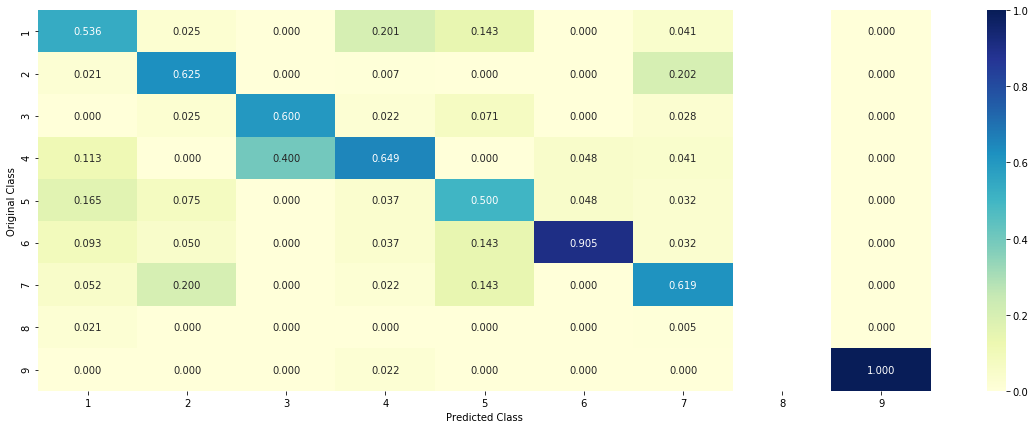

-------------------- Recall matrix (Row sum=1) --------------------


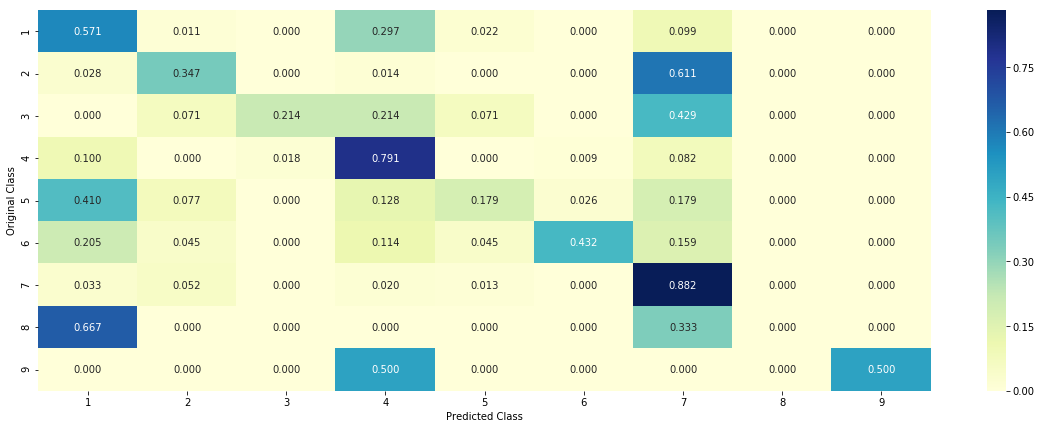

In [16]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding_tfidf, train_y,cv_x_onehotCoding_tfidf,cv_y, clf)

<h2>4.7 Stack the models </h2>

<h3>4.7.1 testing with hyper parameter tuning</h3>

In [17]:
clf1 = SGDClassifier(alpha=0.0001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding_tfidf, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=0.001, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding_tfidf, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.01)
clf3.fit(train_x_onehotCoding_tfidf, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_onehotCoding_tfidf, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_onehotCoding_tfidf))))
sig_clf2.fit(train_x_onehotCoding_tfidf, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_onehotCoding_tfidf))))
sig_clf3.fit(train_x_onehotCoding_tfidf, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_onehotCoding_tfidf))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehotCoding_tfidf, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding_tfidf))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding_tfidf))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 0.99
Support vector machines : Log Loss: 1.10
Naive Bayes : Log Loss: 1.17
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 2.174
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 2.004
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.426
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.072
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.178
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.467


<h3>4.7.2 testing the model with the best hyper parameters</h3>

Log loss (train) on the stacking classifier : 0.4087535598360579
Log loss (CV) on the stacking classifier : 1.0724348110811674
Log loss (test) on the stacking classifier : 1.0518120276548095
Number of missclassified point : 0.3293233082706767
-------------------- Confusion matrix --------------------


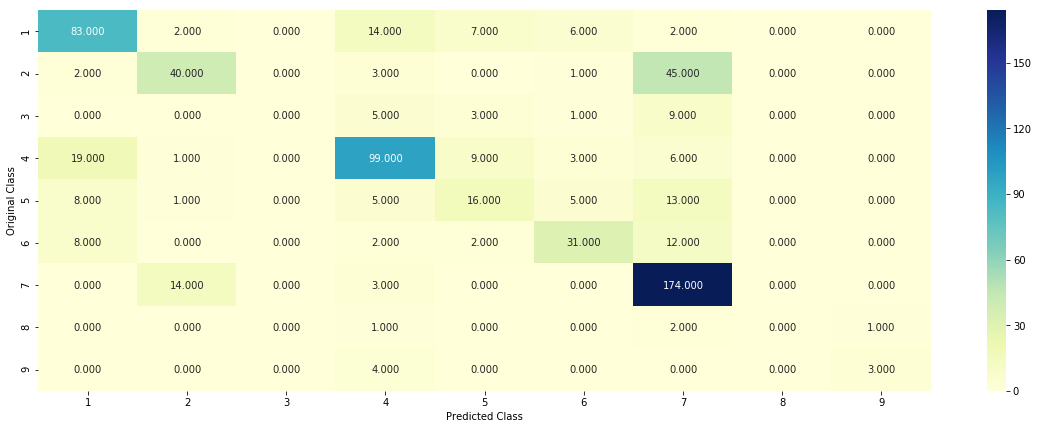

-------------------- Precision matrix (Columm Sum=1) --------------------


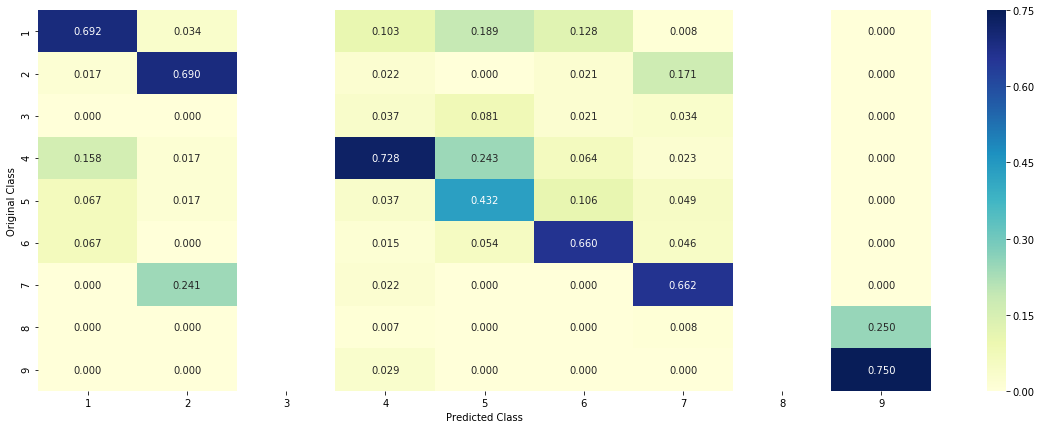

-------------------- Recall matrix (Row sum=1) --------------------


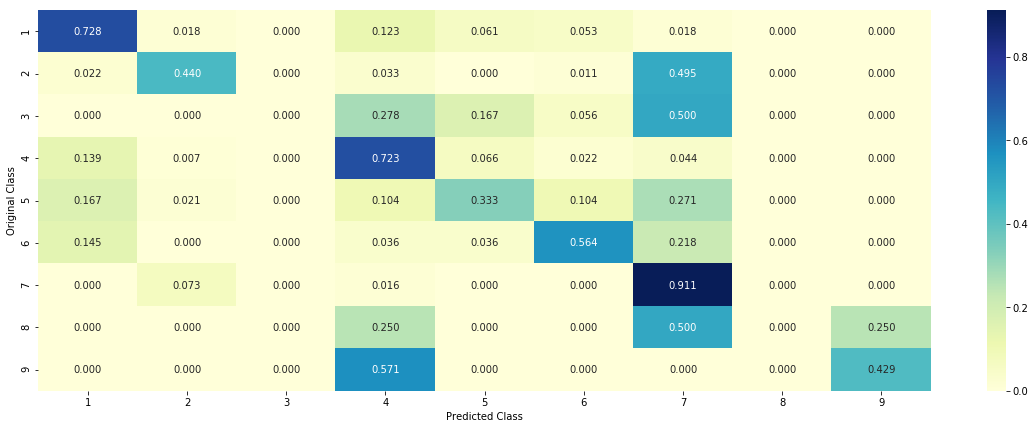

In [18]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding_tfidf, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding_tfidf))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding_tfidf))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding_tfidf))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_onehotCoding_tfidf)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_onehotCoding_tfidf))

Log loss (train) on the VotingClassifier : 0.5305362656541813
Log loss (CV) on the VotingClassifier : 1.0577651794791425
Log loss (test) on the VotingClassifier : 1.0329447061287471
Number of missclassified point : 0.324812030075188
-------------------- Confusion matrix --------------------


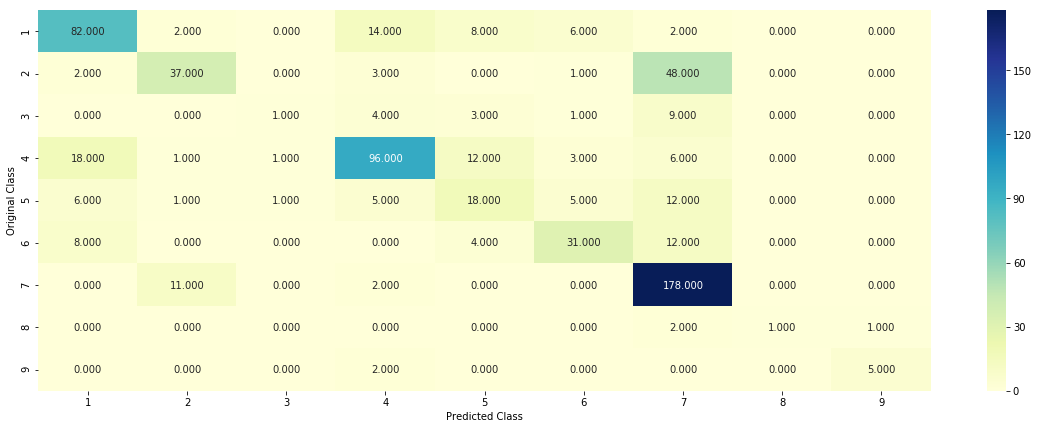

-------------------- Precision matrix (Columm Sum=1) --------------------


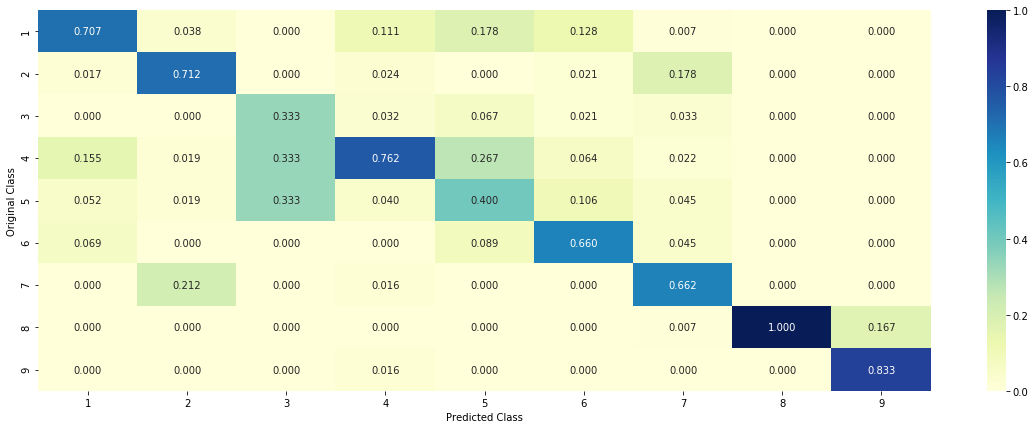

-------------------- Recall matrix (Row sum=1) --------------------


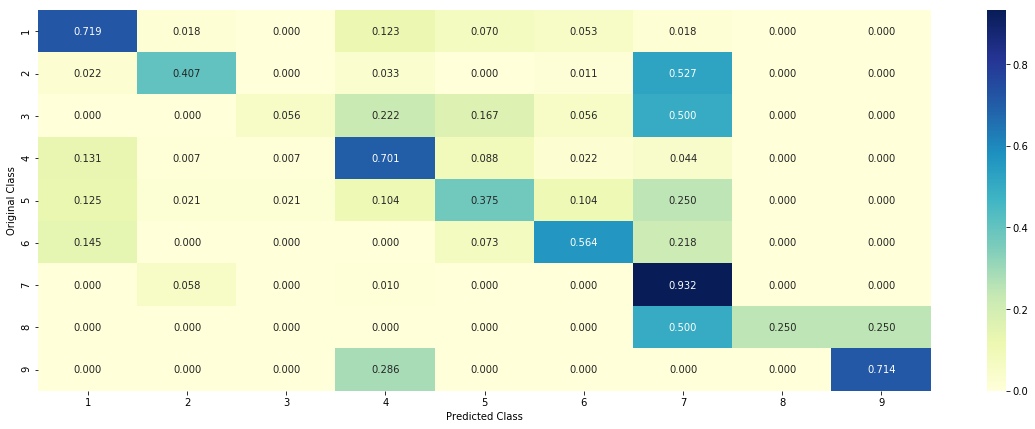

In [19]:
#Refer:http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft')
vclf.fit(train_x_onehotCoding_tfidf, train_y)
print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x_onehotCoding_tfidf)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x_onehotCoding_tfidf)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x_onehotCoding_tfidf)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_onehotCoding_tfidf)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x_onehotCoding_tfidf))

# Task 2

In [10]:
# Select top 1000 words based on their idf values
train_text_feature_tfidf_top_1000 = train_text_feature_tfidf[:, np.argsort(text_vectorizer_tfidf.idf_)[:1000]]

In [11]:
# Normalize text vectors to have unit magnitude
train_text_feature_tfidf_top_1000 = normalize(train_text_feature_tfidf_top_1000)

# Repeat for test and cv text data
test_text_feature_tfidf_top_1000 = text_vectorizer_tfidf.transform(test_df['TEXT'])[:, np.argsort(text_vectorizer_tfidf.idf_)[:1000]]
test_text_feature_tfidf_top_1000 = normalize(test_text_feature_tfidf_top_1000)

cv_text_feature_tfidf_top_1000 = text_vectorizer_tfidf.transform(cv_df['TEXT'])[:, np.argsort(text_vectorizer_tfidf.idf_)[:1000]]
cv_text_feature_tfidf_top_1000 = normalize(cv_text_feature_tfidf_top_1000)

In [14]:
# Stack gene, variation and text features horizontally
train_x_onehotCoding_tfidf_top_1000 = hstack([train_gene_var_onehotCoding, train_text_feature_tfidf_top_1000])

test_x_onehotCoding_tfidf_top_1000 = hstack((test_gene_var_onehotCoding, test_text_feature_tfidf_top_1000))

cv_x_onehotCoding_tfidf_top_1000 = hstack((cv_gene_var_onehotCoding, cv_text_feature_tfidf_top_1000))

In [15]:
train_y = np.array(list(train_df['Class']))
test_y=np.array(list(test_df['Class']))
cv_y=np.array(list(cv_df['Class']))

## Naive bayes with top 1000 words based on IDF

for alpha = 1e-05
Log Loss : 1.286160687658392
for alpha = 0.0001
Log Loss : 1.2861204177456227
for alpha = 0.001
Log Loss : 1.2850048403471175
for alpha = 0.01
Log Loss : 1.2794544484889725
for alpha = 0.1
Log Loss : 1.2921826058802897
for alpha = 1
Log Loss : 1.3135636682456877
for alpha = 10
Log Loss : 1.3898200348874643
for alpha = 100
Log Loss : 1.3825935461731855
for alpha = 1000
Log Loss : 1.3791787528981037


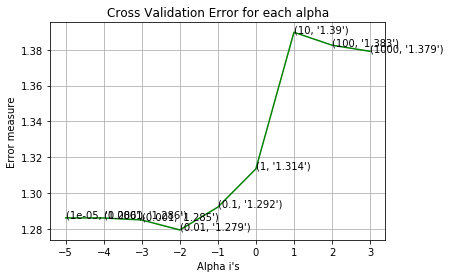

For values of best alpha =  0.01 The train log loss is: 0.5312634013527103
For values of best alpha =  0.01 The cross validation log loss is: 1.2794544484889725
For values of best alpha =  0.01 The test log loss is: 1.1543754226547898


In [43]:
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding_tfidf_top_1000, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding_tfidf_top_1000, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding_tfidf_top_1000)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs, eps=1e-15)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding_tfidf_top_1000, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding_tfidf_top_1000, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding_tfidf_top_1000)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding_tfidf_top_1000)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding_tfidf_top_1000)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


Log Loss : 1.1543754226547898
Number of missclassified point : 0.37142857142857144
-------------------- Confusion matrix --------------------


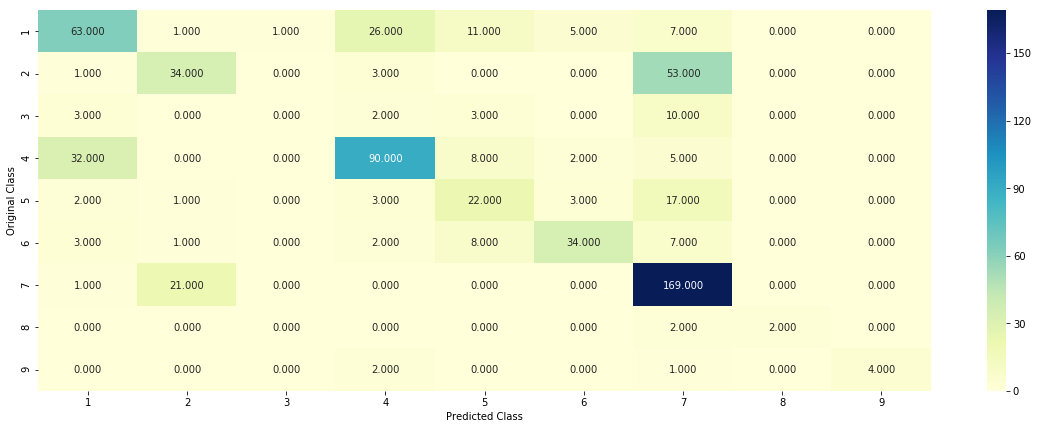

-------------------- Precision matrix (Columm Sum=1) --------------------


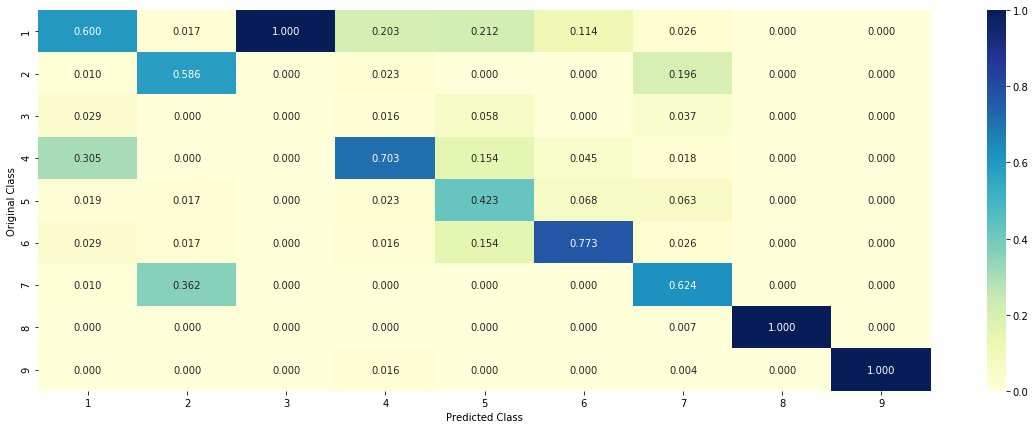

-------------------- Recall matrix (Row sum=1) --------------------


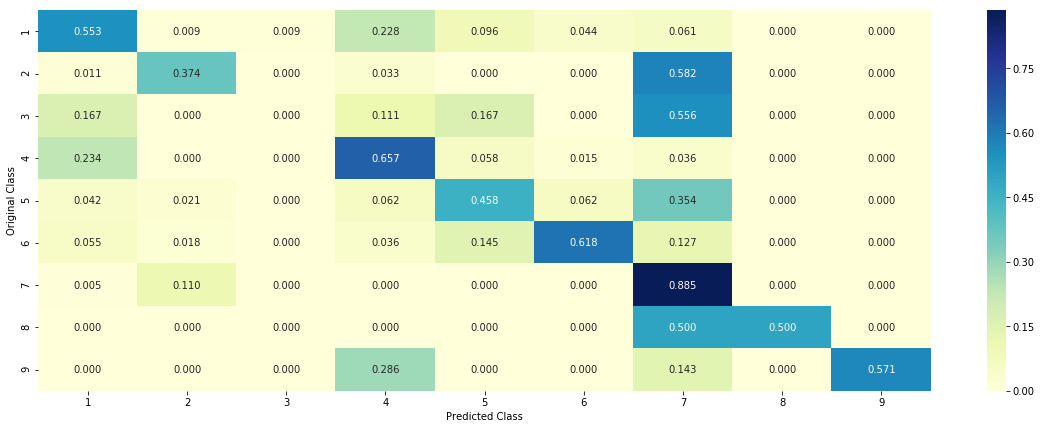

In [44]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding_tfidf_top_1000, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding_tfidf_top_1000, train_y)
sig_clf_probs = sig_clf.predict_proba(test_x_onehotCoding_tfidf_top_1000)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(test_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(test_x_onehotCoding_tfidf_top_1000)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y, sig_clf.predict(test_x_onehotCoding_tfidf_top_1000))

<h2>4.3. Logistic Regression with class balancing</h2>

for alpha = 1e-06
Log Loss : 1.0920811169337086
for alpha = 1e-05
Log Loss : 1.0757490934065783
for alpha = 0.0001
Log Loss : 1.018751849151804
for alpha = 0.001
Log Loss : 1.059574453538058
for alpha = 0.01
Log Loss : 1.2066517350472108
for alpha = 0.1
Log Loss : 1.5319248397794525
for alpha = 1
Log Loss : 1.6749323173577424
for alpha = 10
Log Loss : 1.6923346802981227
for alpha = 100
Log Loss : 1.6942085626635395


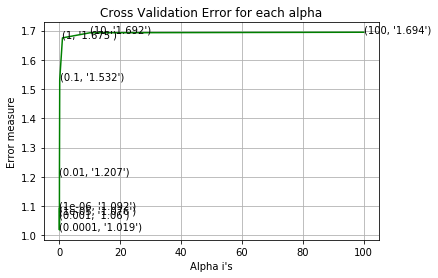

For values of best alpha =  0.0001 The train log loss is: 0.45658021858652154
For values of best alpha =  0.0001 The cross validation log loss is: 1.018751849151804
For values of best alpha =  0.0001 The test log loss is: 1.003789417213948


In [17]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding_tfidf_top_1000, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding_tfidf_top_1000, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding_tfidf_top_1000)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding_tfidf_top_1000, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding_tfidf_top_1000, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding_tfidf_top_1000)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding_tfidf_top_1000)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding_tfidf_top_1000)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.018751849151804
Number of mis-classified points : 0.33270676691729323
-------------------- Confusion matrix --------------------


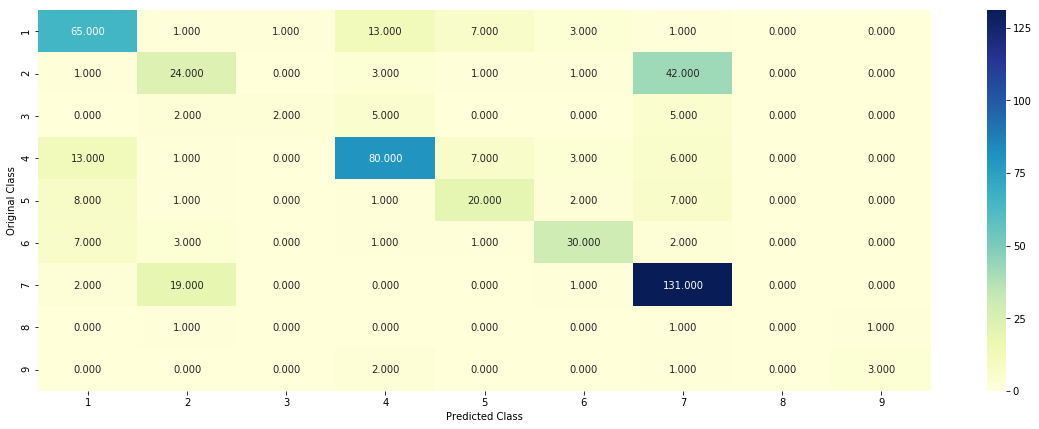

-------------------- Precision matrix (Columm Sum=1) --------------------


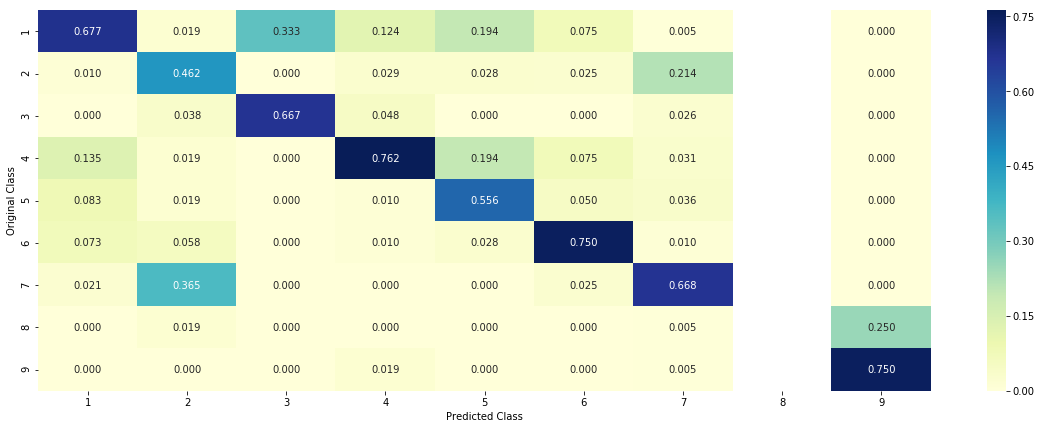

-------------------- Recall matrix (Row sum=1) --------------------


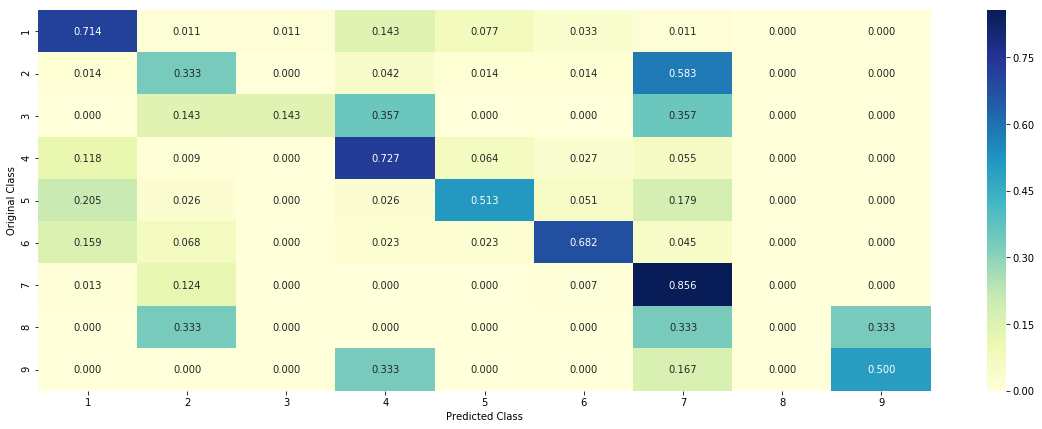

In [20]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding_tfidf_top_1000, train_y, cv_x_onehotCoding_tfidf_top_1000, cv_y, clf)

<h2>4.4. Linear Support Vector Machines</h2>
<h3>4.4.1. Hyper paramter tuning</h3>

for C = 1e-05
Log Loss : 1.1080454226304972
for C = 0.0001
Log Loss : 1.0642018165740585
for C = 0.001
Log Loss : 1.096605859110875
for C = 0.01
Log Loss : 1.2595138382769553
for C = 0.1
Log Loss : 1.5964441347021645
for C = 1
Log Loss : 1.6945596462996493
for C = 10
Log Loss : 1.694559640932701
for C = 100
Log Loss : 1.694559642252213


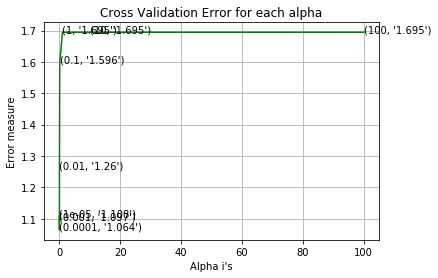

For values of best alpha =  0.0001 The train log loss is: 0.4946983916307175
For values of best alpha =  0.0001 The cross validation log loss is: 1.0642018165740585
For values of best alpha =  0.0001 The test log loss is: 1.063235020717038


In [21]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding_tfidf_top_1000, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding_tfidf_top_1000, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding_tfidf_top_1000)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding_tfidf_top_1000, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding_tfidf_top_1000, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding_tfidf_top_1000)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding_tfidf_top_1000)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding_tfidf_top_1000)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.0642018165740585
Number of mis-classified points : 0.34210526315789475
-------------------- Confusion matrix --------------------


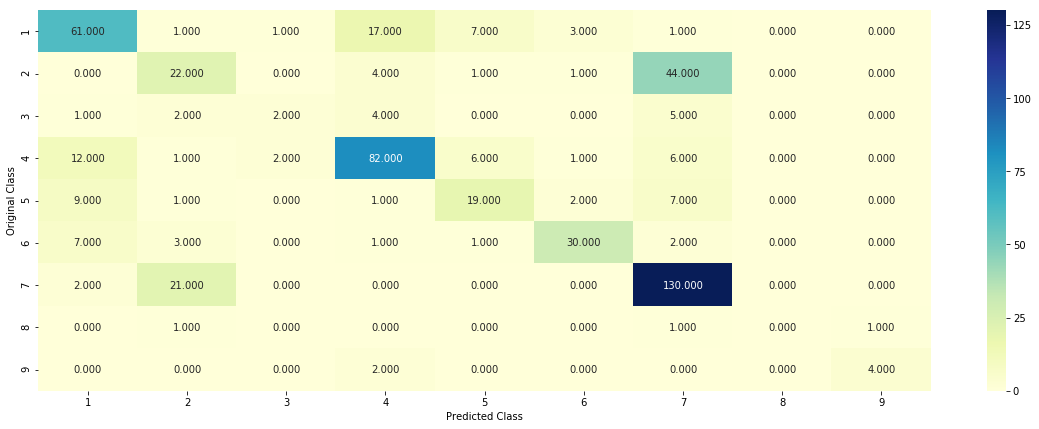

-------------------- Precision matrix (Columm Sum=1) --------------------


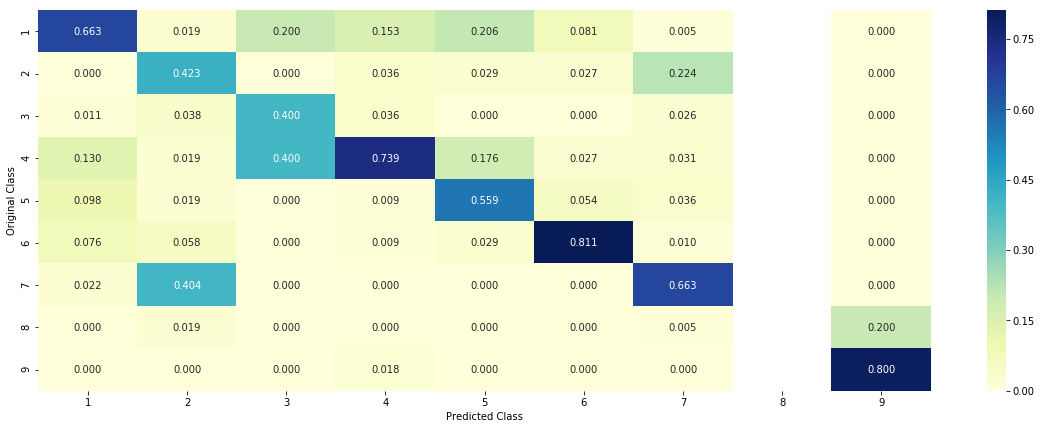

-------------------- Recall matrix (Row sum=1) --------------------


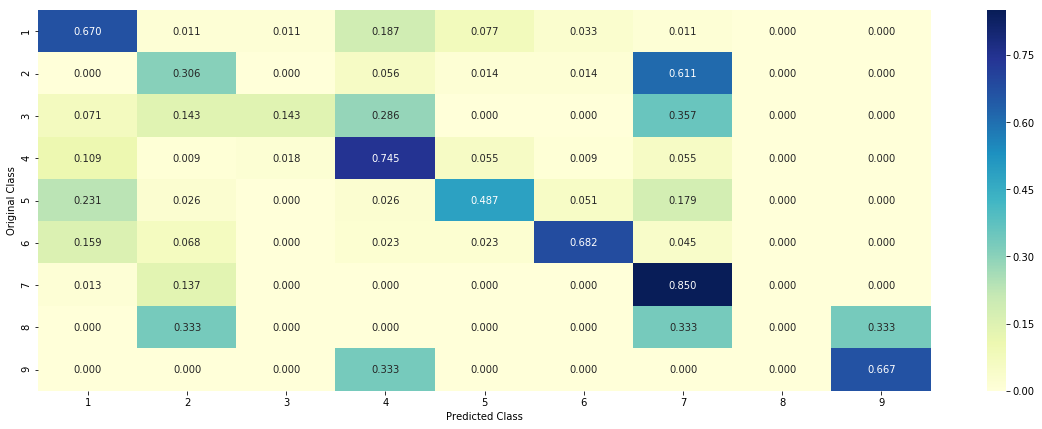

In [22]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding_tfidf_top_1000, train_y, cv_x_onehotCoding_tfidf_top_1000, cv_y, clf)

<h2>4.5 Random Forest Classifier</h2>
<h3>4.5.1. Hyper paramter tuning (With TF IDF using top 1000 words)</h3>

In [23]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding_tfidf_top_1000, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding_tfidf_top_1000, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding_tfidf_top_1000)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15)) 

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding_tfidf_top_1000, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding_tfidf_top_1000, train_y)
    
predict_y = sig_clf.predict_proba(train_x_onehotCoding_tfidf_top_1000)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding_tfidf_top_1000)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding_tfidf_top_1000)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 100 and max depth =  5
Log Loss : 1.1208779688969168
for n_estimators = 100 and max depth =  10
Log Loss : 1.0949073443642627
for n_estimators = 200 and max depth =  5
Log Loss : 1.1019374316322113
for n_estimators = 200 and max depth =  10
Log Loss : 1.0925043919391253
for n_estimators = 500 and max depth =  5
Log Loss : 1.093135997474038
for n_estimators = 500 and max depth =  10
Log Loss : 1.0885371117041478
for n_estimators = 1000 and max depth =  5
Log Loss : 1.091905478161252
for n_estimators = 1000 and max depth =  10
Log Loss : 1.087054770236635
for n_estimators = 2000 and max depth =  5
Log Loss : 1.0915160294910533
for n_estimators = 2000 and max depth =  10
Log Loss : 1.087185532324093
For values of best estimator =  1000 The train log loss is: 0.5552132216962793
For values of best estimator =  1000 The cross validation log loss is: 1.087054770236635
For values of best estimator =  1000 The test log loss is: 1.0780155129798825


Log loss : 1.087054770236635
Number of mis-classified points : 0.3458646616541353
-------------------- Confusion matrix --------------------


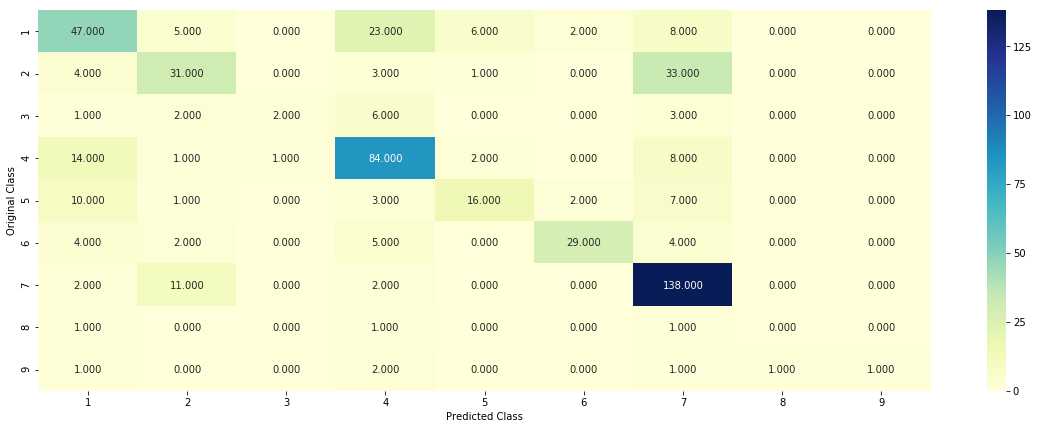

-------------------- Precision matrix (Columm Sum=1) --------------------


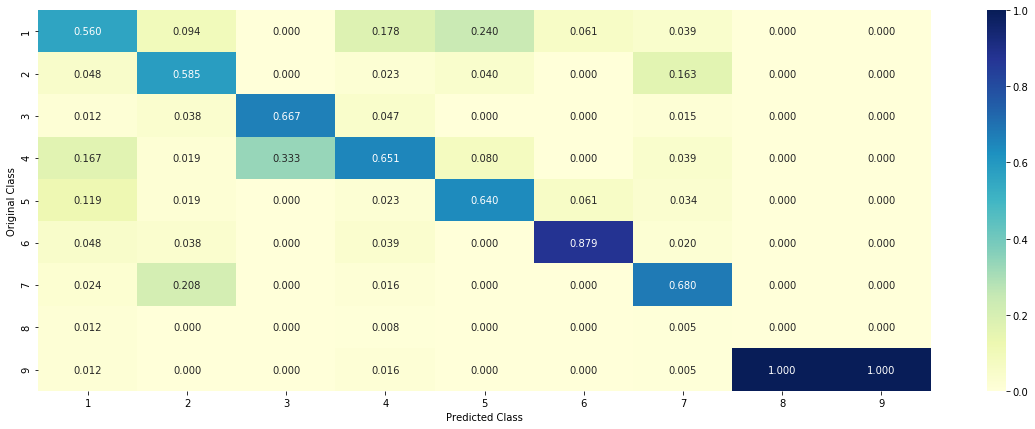

-------------------- Recall matrix (Row sum=1) --------------------


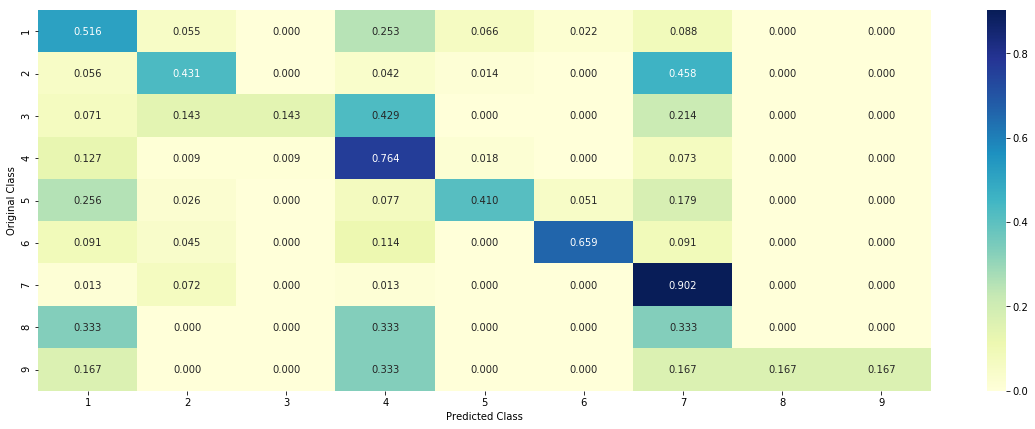

In [25]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding_tfidf_top_1000, train_y,cv_x_onehotCoding_tfidf_top_1000,cv_y, clf)

<h2>4.7 Stack the models </h2>

In [28]:
clf1 = SGDClassifier(alpha=0.0001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding_tfidf_top_1000, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=0.0001, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding_tfidf_top_1000, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.01)
clf3.fit(train_x_onehotCoding_tfidf_top_1000, y_train)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_onehotCoding_tfidf_top_1000, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_onehotCoding_tfidf_top_1000))))
sig_clf2.fit(train_x_onehotCoding_tfidf_top_1000, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_onehotCoding_tfidf_top_1000))))
sig_clf3.fit(train_x_onehotCoding_tfidf_top_1000, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_onehotCoding_tfidf_top_1000))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehotCoding_tfidf_top_1000, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding_tfidf_top_1000))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding_tfidf_top_1000))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.01
Support vector machines : Log Loss: 1.06
Naive Bayes : Log Loss: 1.15
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 2.173
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 1.995
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.402
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.063
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.243
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.680


Log loss (train) on the VotingClassifier : 0.4792340737934767
Log loss (CV) on the VotingClassifier : 1.0376771968257628
Log loss (test) on the VotingClassifier : 1.0236224553659548
Number of missclassified point : 0.3548872180451128
-------------------- Confusion matrix --------------------


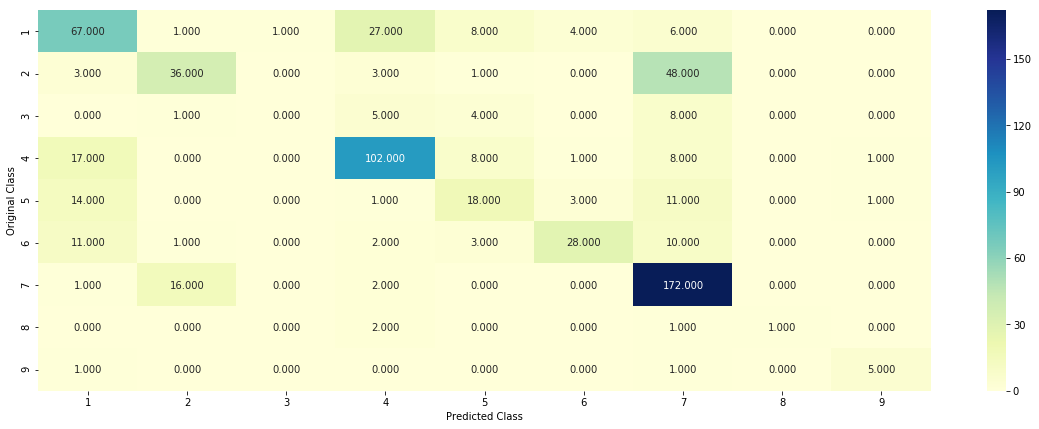

-------------------- Precision matrix (Columm Sum=1) --------------------


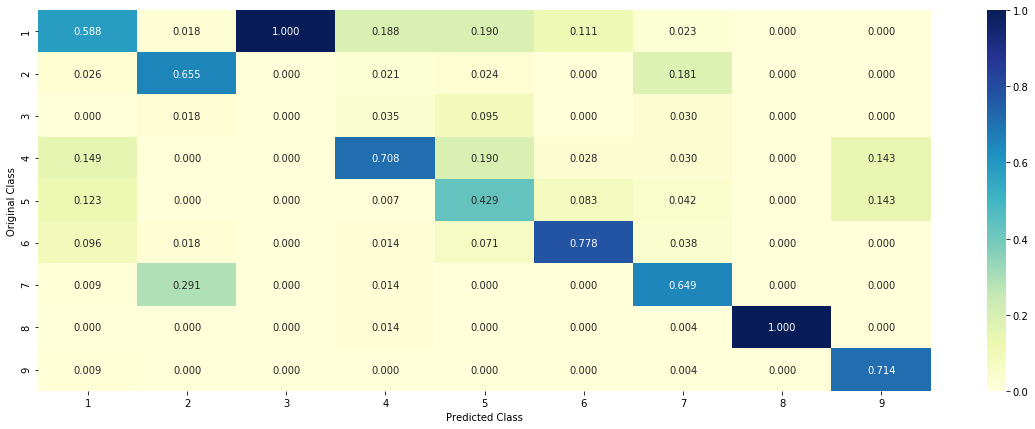

-------------------- Recall matrix (Row sum=1) --------------------


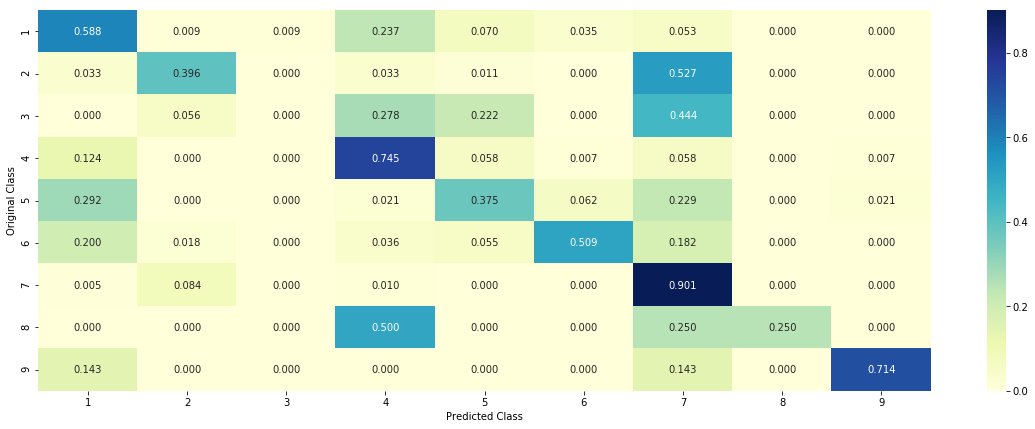

In [16]:
#Refer:http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('nb', sig_clf3)], voting='soft')
vclf.fit(train_x_onehotCoding_tfidf_top_1000, y_train)
print("Log loss (train) on the VotingClassifier :", log_loss(y_train, vclf.predict_proba(train_x_onehotCoding_tfidf_top_1000)))
print("Log loss (CV) on the VotingClassifier :", log_loss(y_cv, vclf.predict_proba(cv_x_onehotCoding_tfidf_top_1000)))
print("Log loss (test) on the VotingClassifier :", log_loss(y_test, vclf.predict_proba(test_x_onehotCoding_tfidf_top_1000)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_onehotCoding_tfidf_top_1000)- y_test))/y_test.shape[0])
plot_confusion_matrix(test_y=y_test, predict_y=vclf.predict(test_x_onehotCoding_tfidf_top_1000))

# Task 3

In [17]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3, ngram_range=(1,2))
train_text_feature_onehotCoding_bigrams = text_vectorizer.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding_bigrams.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique 1-grams and 2-grams in train data :", len(train_text_features))

Total number of unique 1-grams and 2-grams in train data : 757848


In [21]:
cv_text_onehotCoding_bigrams=text_vectorizer.transform(cv_df['TEXT'])
test_text_onehotCoding_bigrams=text_vectorizer.transform(test_df['TEXT'])

## Stacking new text features with gene_var features

In [22]:
train_x_onehotCoding_bigrams = hstack([train_gene_var_onehotCoding, train_text_feature_onehotCoding_bigrams])

test_x_onehotCoding_bigrams = hstack((test_gene_var_onehotCoding, test_text_onehotCoding_bigrams))

cv_x_onehotCoding_bigrams = hstack((cv_gene_var_onehotCoding, cv_text_onehotCoding_bigrams))

<h2>4.3. Logistic Regression with class balancing</h2>

for alpha = 1
Log Loss : 1.3507487159329974
for alpha = 10
Log Loss : 1.256827009103932
for alpha = 100
Log Loss : 1.3177377168372668
for alpha = 1000
Log Loss : 1.6364625449802752
for alpha = 10000
Log Loss : 1.7896286837823396
for alpha = 100000
Log Loss : 1.7995644401484474


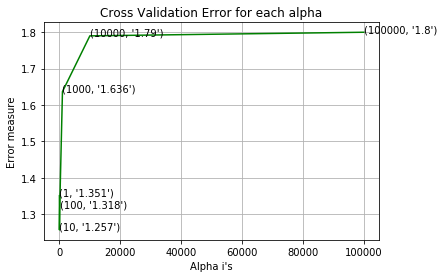

For values of best alpha =  10 The train log loss is: 0.9819582793112583
For values of best alpha =  10 The cross validation log loss is: 1.256827009103932
For values of best alpha =  10 The test log loss is: 1.24814727841779


In [24]:
alpha = [10 ** x for x in range(0, 6)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding_bigrams, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding_bigrams, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding_bigrams)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding_bigrams, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding_bigrams, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding_bigrams)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding_bigrams)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding_bigrams)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

In [25]:
clf=SGDClassifier(class_weight='balanced', random_state=42, loss='log', alpha=10)
clf.fit(train_x_onehotCoding_bigrams, y_train)

SGDClassifier(alpha=10, average=False, class_weight='balanced', epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

Log loss : 1.24814727841779
Number of mis-classified points : 0.4180451127819549
-------------------- Confusion matrix --------------------


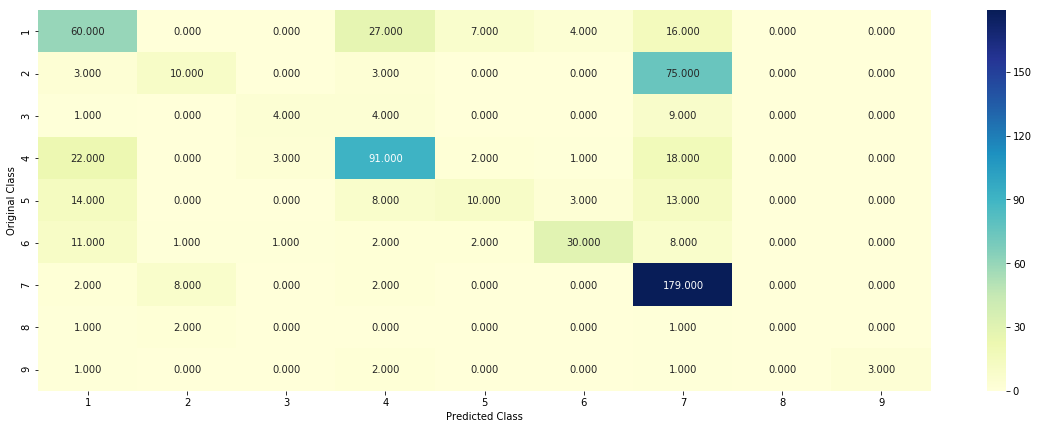

-------------------- Precision matrix (Columm Sum=1) --------------------


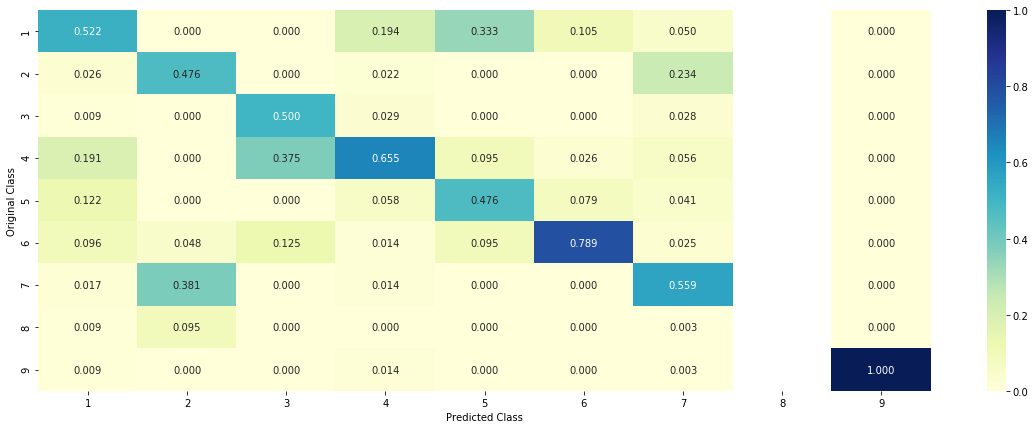

-------------------- Recall matrix (Row sum=1) --------------------


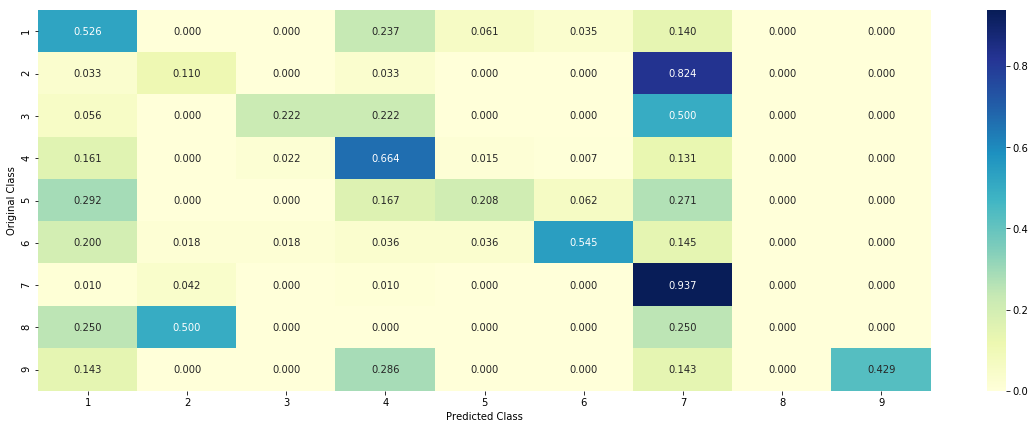

In [27]:
predict_and_plot_confusion_matrix(train_x_onehotCoding_bigrams, train_y, test_x_onehotCoding_bigrams, test_y, clf)

# Task 4

In [39]:
import scipy.stats as stats
import pylab

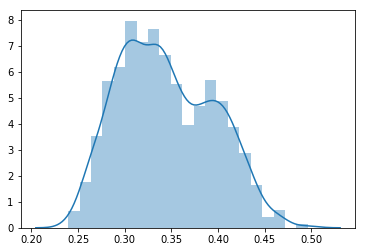

In [36]:
%matplotlib inline
sns.distplot(train_x_responseCoding[:,18])

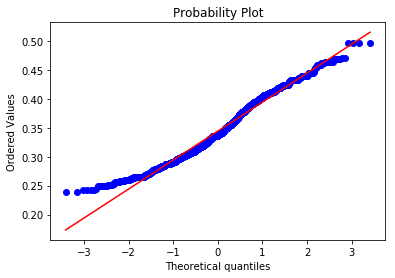

In [48]:
stats.probplot(train_x_responseCoding[:,18], dist="norm", plot=pylab)
pylab.show()

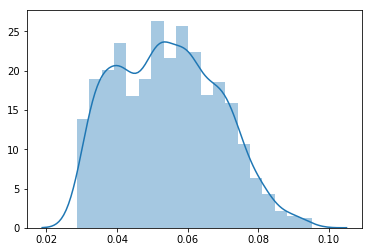

In [37]:
sns.distplot(train_x_responseCoding[:,19])

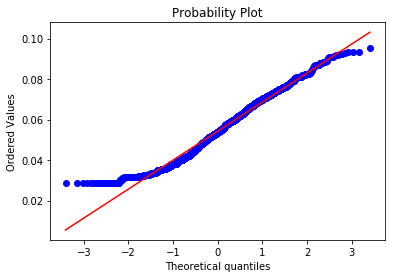

In [49]:
stats.probplot(train_x_responseCoding[:,19], dist="norm", plot=pylab)
pylab.show()

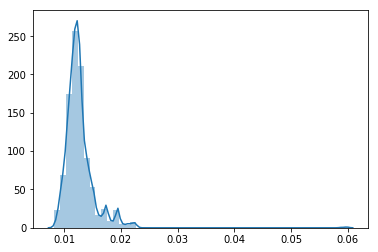

In [38]:
sns.distplot(train_x_responseCoding[:,20])

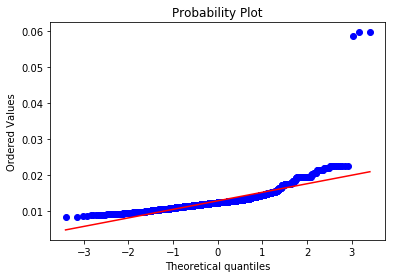

In [50]:
stats.probplot(train_x_responseCoding[:,20], dist="norm", plot=pylab)
pylab.show()

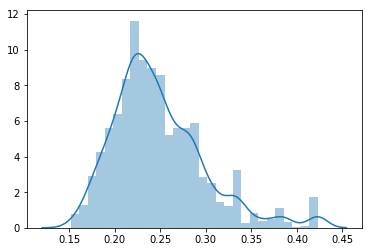

In [39]:
sns.distplot(train_x_responseCoding[:,21])

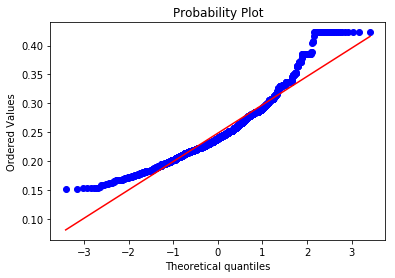

In [51]:
stats.probplot(train_x_responseCoding[:,21], dist="norm", plot=pylab)
pylab.show()

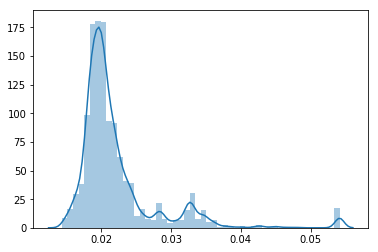

In [40]:
sns.distplot(train_x_responseCoding[:,22])

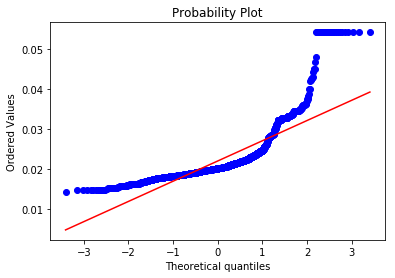

In [52]:
stats.probplot(train_x_responseCoding[:,22], dist="norm", plot=pylab)
pylab.show()

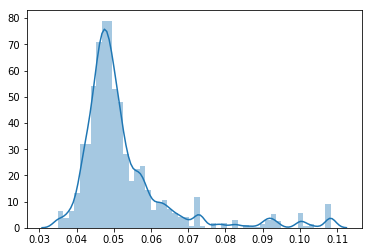

In [41]:
sns.distplot(train_x_responseCoding[:,23])

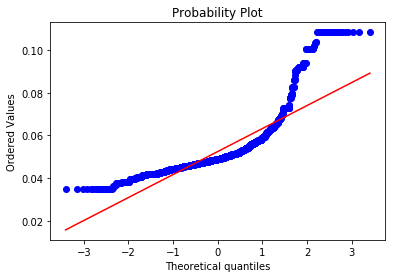

In [53]:
stats.probplot(train_x_responseCoding[:,23], dist="norm", plot=pylab)
pylab.show()

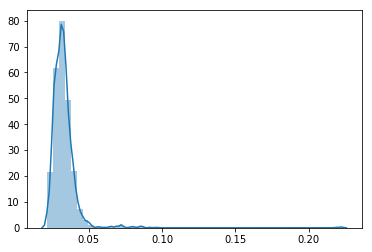

In [44]:
sns.distplot(train_x_responseCoding[:,26])

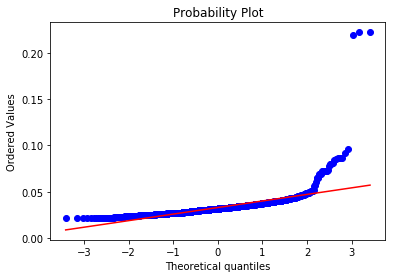

In [54]:
stats.probplot(train_x_responseCoding[:,26], dist="norm", plot=pylab)
pylab.show()

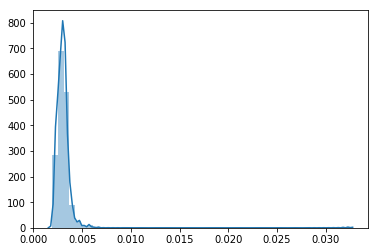

In [43]:
sns.distplot(train_x_responseCoding[:,25])

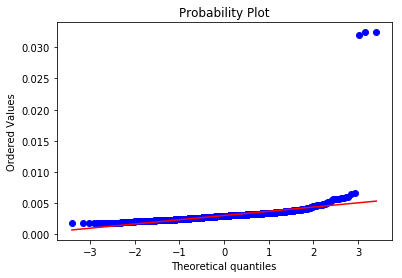

In [55]:
stats.probplot(train_x_responseCoding[:,25], dist="norm", plot=pylab)
pylab.show()

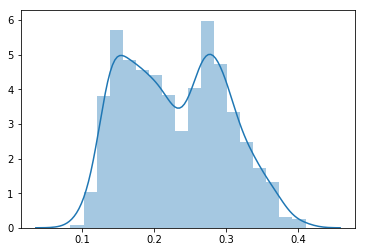

In [70]:
sns.distplot(train_x_responseCoding[:,24])

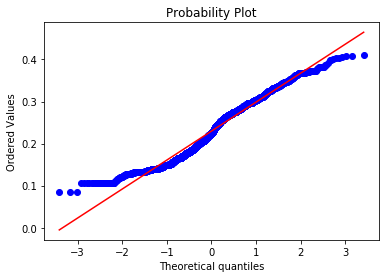

In [71]:
stats.probplot(train_x_responseCoding[:,24], dist="norm", plot=pylab)
pylab.show()

Features 18-21 and 24-26 are gaussian distributed. No need to transform them for logistic regression.

## Handling non gaussian features

In [18]:
from scipy.stats import boxcox
from sklearn.preprocessing import StandardScaler

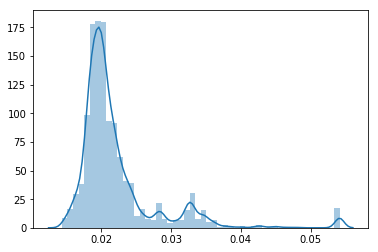

In [72]:
sns.distplot(train_x_responseCoding[:,22])

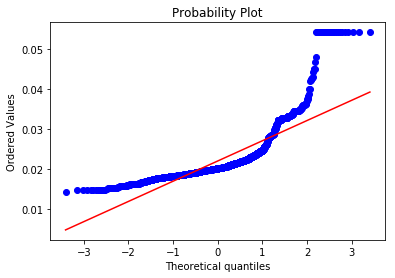

In [73]:
stats.probplot(train_x_responseCoding[:,22], dist="norm", plot=pylab)
pylab.show()

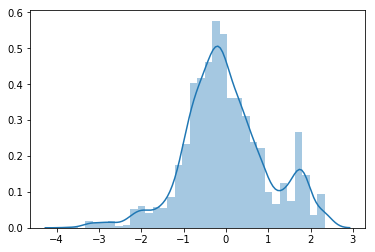

In [83]:
sns.distplot(StandardScaler().fit_transform(np.reshape(boxcox(train_x_responseCoding[:,22])[0], (-1, 1))))

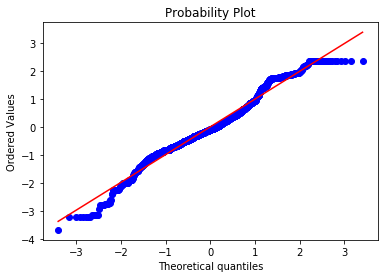

In [90]:
stats.probplot((StandardScaler().fit_transform(np.reshape(boxcox(train_x_responseCoding[:,22])[0], (-1, 1)))).flatten(), dist="norm", plot=pylab)
pylab.show()

Use box cox transformed feature 22 after standardisation instead of raw feature 22

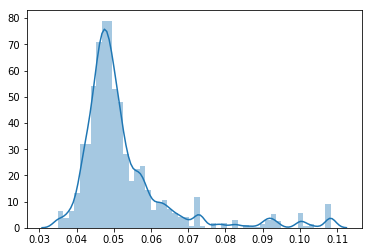

In [92]:
sns.distplot(train_x_responseCoding[:,23])

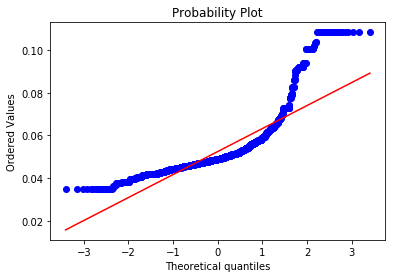

In [93]:
stats.probplot(train_x_responseCoding[:,23], dist="norm", plot=pylab)
pylab.show()

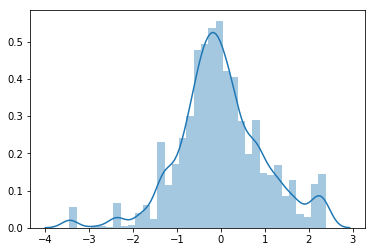

In [95]:
sns.distplot(StandardScaler().fit_transform(np.reshape(boxcox(train_x_responseCoding[:,23])[0], (-1, 1))))

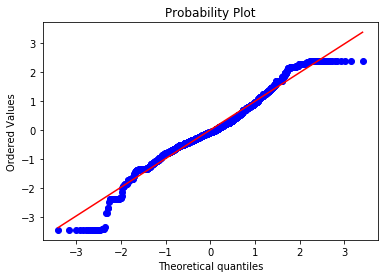

In [96]:
stats.probplot((StandardScaler().fit_transform(np.reshape(boxcox(train_x_responseCoding[:,23])[0], (-1, 1)))).flatten(), dist="norm", plot=pylab)
pylab.show()

Use box cox transformed feature 23 after standardisation instead of raw feature 23

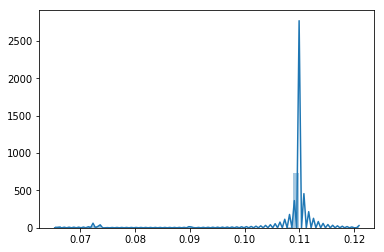

In [97]:
sns.distplot(train_x_responseCoding[:,17])

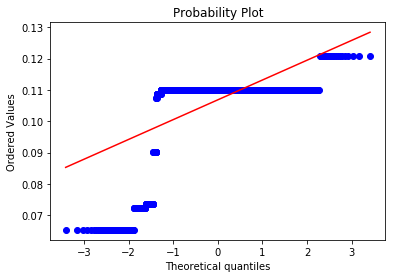

In [98]:
stats.probplot(train_x_responseCoding[:,17], dist="norm", plot=pylab)
pylab.show()

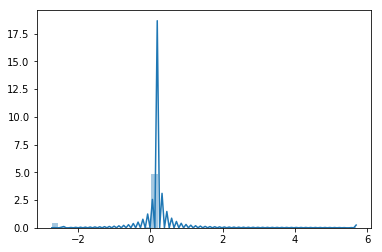

In [99]:
sns.distplot(StandardScaler().fit_transform(np.reshape(boxcox(train_x_responseCoding[:,17])[0], (-1, 1))))

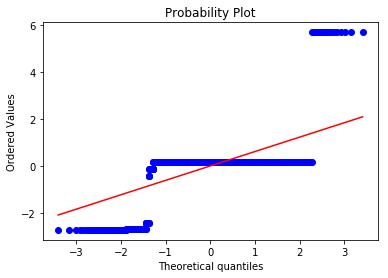

In [100]:
stats.probplot((StandardScaler().fit_transform(np.reshape(boxcox(train_x_responseCoding[:,17])[0], (-1, 1)))).flatten(), dist="norm", plot=pylab)
pylab.show()

Even box cox can't do nothing for feature 17

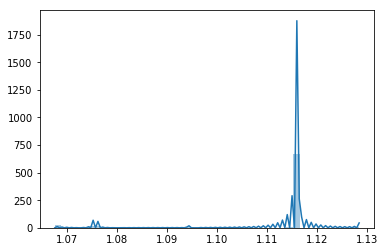

In [111]:
sns.distplot(np.exp(train_x_responseCoding[:,17]))

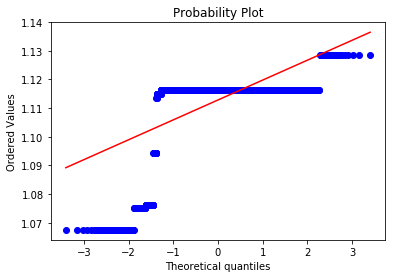

In [112]:
stats.probplot(np.exp(train_x_responseCoding[:,17]), dist="norm", plot=pylab)
pylab.show()

Taking exp, log, sin, cos, tan has no effect either

### Feature binning of feature 17

In [53]:
from sklearn.tree import DecisionTreeClassifier

In [54]:
dtree=DecisionTreeClassifier(max_leaf_nodes=9)
dtree.fit(train_x_responseCoding[:,17:18],y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=9, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [55]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

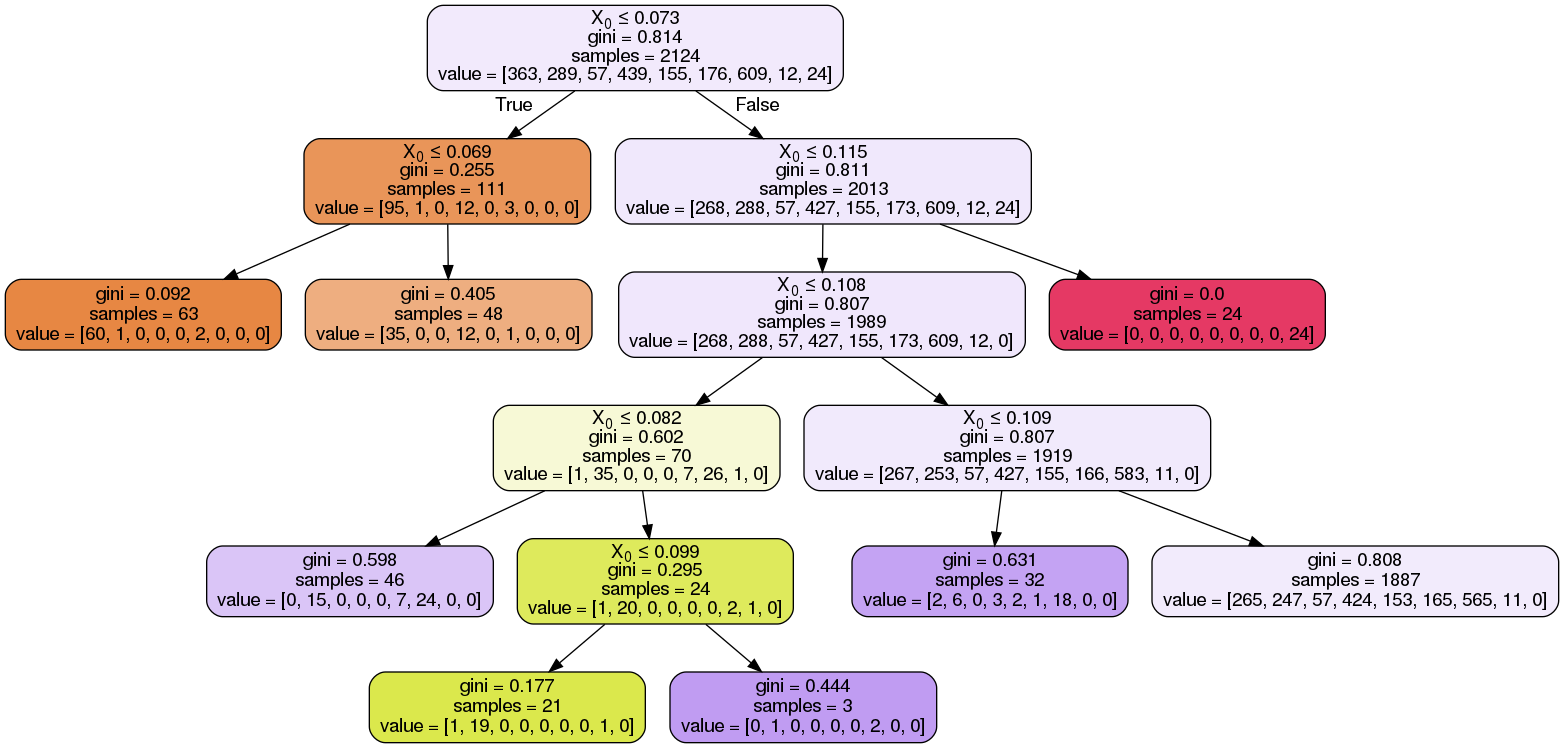

In [118]:
dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [15]:
# D tree based binning of feature 17
def bin_func_17(x):
    if x<=0.073:
        if x<=0.069:
            return 0
        return 1
    if x<=0.115:
        if x<=0.108:
            if x<=0.082:
                return 2
            if x<=0.099:
                return 3
            return 4
        if x<0.109:
            return 5
        return 6
    return 7

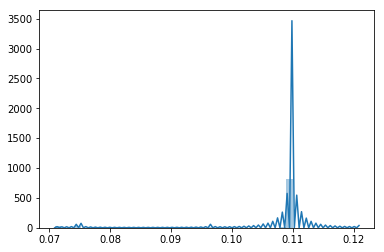

In [20]:
%matplotlib inline
sns.distplot(train_x_responseCoding[:,16])

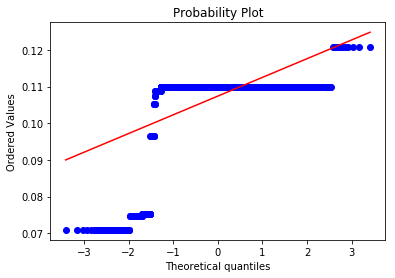

In [21]:
stats.probplot(train_x_responseCoding[:,16], dist="norm", plot=pylab)
pylab.show()

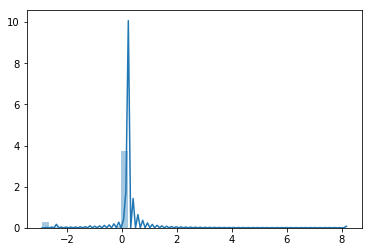

In [22]:
sns.distplot(StandardScaler().fit_transform(np.reshape(boxcox(train_x_responseCoding[:,16])[0], (-1, 1))))

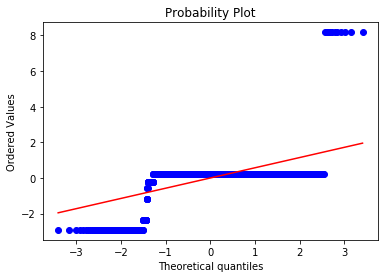

In [23]:
stats.probplot((StandardScaler().fit_transform(np.reshape(boxcox(train_x_responseCoding[:,16])[0], (-1, 1)))).flatten(), dist="norm", plot=pylab)
pylab.show()

Even Box-cox can't do nothing for feature 16

In [27]:
dtree=DecisionTreeClassifier(max_leaf_nodes=9)
dtree.fit(train_x_responseCoding[:,16:17],y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=9, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

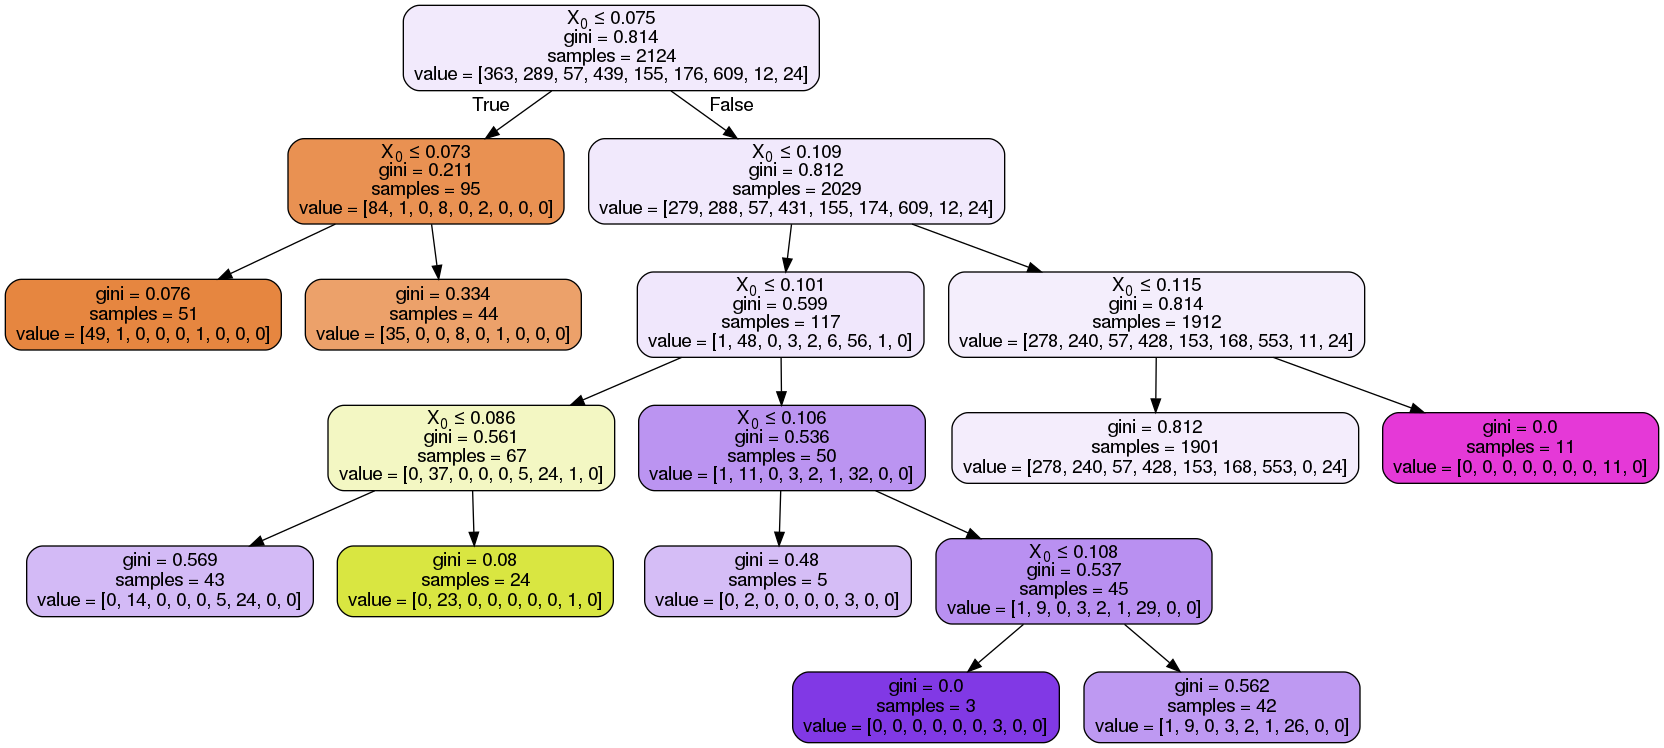

In [29]:
dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [16]:
# Dtree based feature binning of feature 16
def bin_func_16(x):
    if x<=0.075:
        if x<=0.073:
            return 0
        return 1
    if x<=0.109:
        if x<=0.101:
            if x<=0.086:
                return 2
            return 3
        if x<=0.106:
            return 4
        if x<=0.108:
            return 5
        return 6
    if x<=0.115:
        return 7
    return 8

## Feature transformations

In [19]:
# features 18-21 and 25, 26 are gaussian and only need to be standardised
# features 22 and 23 come close to gaussian distribution when box-cox transformed
feature_22=np.concatenate((train_x_responseCoding[:, 22:23], cv_x_responseCoding[:, 22:23], test_x_responseCoding[:, 22:23]), axis=0)
feature_22=boxcox(feature_22)[0]

feature_23=np.concatenate((train_x_responseCoding[:, 23:24], cv_x_responseCoding[:, 23:24], test_x_responseCoding[:, 23:24]), axis=0)
feature_23=boxcox(feature_23)[0]

feature_22_train=feature_22[:, :len(train_x_responseCoding)]
feature_22_cv=feature_22[:, len(train_x_responseCoding): len(train_x_responseCoding)+len(cv_x_responseCoding)]
feature_22_test=feature_22[:, len(train_x_responseCoding)+len(cv_x_responseCoding) : len(train_x_responseCoding)+len(cv_x_responseCoding)+len(test_x_responseCoding)]

feature_23_train=feature_23[:, :len(train_x_responseCoding)]
feature_23_cv=feature_23[:, len(train_x_responseCoding): len(train_x_responseCoding)+len(cv_x_responseCoding)]
feature_23_test=feature_23[:, len(train_x_responseCoding)+len(cv_x_responseCoding) : len(train_x_responseCoding)+len(cv_x_responseCoding)+len(test_x_responseCoding)]

In [32]:
# Binning feature 16 and 17
feature_16=np.concatenate((train_x_responseCoding[:, 16:17], cv_x_responseCoding[:, 16:17], test_x_responseCoding[:, 16:17]), axis=0)
feature_16=np.reshape(np.apply_along_axis(bin_func_16, 1, feature_16), (-1, 1))

feature_17=np.concatenate((train_x_responseCoding[:, 17:18], cv_x_responseCoding[:, 17:18], test_x_responseCoding[:, 17:18]), axis=0)
feature_17=np.reshape(np.apply_along_axis(bin_func_17, 1, feature_17), (-1, 1))

feature_16_train=feature_16[:len(train_x_responseCoding), :]
feature_16_cv=feature_16[len(train_x_responseCoding): len(train_x_responseCoding)+len(cv_x_responseCoding), :]
feature_16_test=feature_16[len(train_x_responseCoding)+len(cv_x_responseCoding) : , :]

feature_17_train=feature_17[:len(train_x_responseCoding), :]
feature_17_cv=feature_17[len(train_x_responseCoding): len(train_x_responseCoding)+len(cv_x_responseCoding), :]
feature_17_test=feature_17[len(train_x_responseCoding)+len(cv_x_responseCoding):, :]

In [33]:
scaler_18_to_21=StandardScaler()
scaler_18_to_21.fit(train_x_responseCoding[:, 18:22])

train_standardised_18_to_21=scaler_18_to_21.transform(train_x_responseCoding[:, 18:22])
cv_standardised_18_to_21=scaler_18_to_21.transform(cv_x_responseCoding[:, 18:22])
test_standardised_18_to_21=scaler_18_to_21.transform(test_x_responseCoding[:, 18:22])

scaler_22_to_26=StandardScaler()
scaler_22_to_26.fit(train_x_responseCoding[:, 22:])

train_standardised_22_to_26=scaler_22_to_26.transform(train_x_responseCoding[:, 22:])
cv_standardised_22_to_26=scaler_22_to_26.transform(cv_x_responseCoding[:, 22:])
test_standardised_22_to_26=scaler_22_to_26.transform(test_x_responseCoding[:, 22:])

In [69]:
train_x_new_features=np.concatenate((feature_16_train, feature_17_train, train_standardised_18_to_21, train_standardised_22_to_26), axis=1)
cv_x_new_features=np.concatenate((feature_16_cv, feature_17_cv, cv_standardised_18_to_21, cv_standardised_22_to_26), axis=1)
test_x_new_features=np.concatenate((feature_16_test, feature_17_test, test_standardised_18_to_21, test_standardised_22_to_26), axis=1)

for alpha = 1e-05
Log Loss : 1.13425809768
for alpha = 0.0001
Log Loss : 1.13962320565
for alpha = 0.001
Log Loss : 1.12121134126
for alpha = 0.01
Log Loss : 1.07379766748
for alpha = 0.1
Log Loss : 1.12532867462
for alpha = 1
Log Loss : 1.50478915615
for alpha = 10
Log Loss : 1.81357361159
for alpha = 100
Log Loss : 1.87175189084
for alpha = 1000
Log Loss : 1.86662970151
for alpha = 10000
Log Loss : 1.86547659591
for alpha = 100000
Log Loss : 1.86507413939


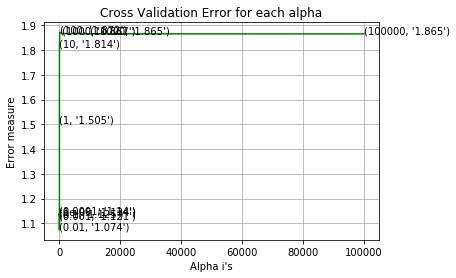

For values of best alpha =  0.01 The train log loss is: 0.799444640164
For values of best alpha =  0.01 The cross validation log loss is: 1.07379766748
For values of best alpha =  0.01 The test log loss is: 1.01856559082


In [72]:
# testing new features

alpha = [10 ** x for x in range(-5, 6)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_new_features[:, :], y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_new_features[:, :], y_train)
    sig_clf_probs = sig_clf.predict_proba(cv_x_new_features[:, :])
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_new_features[:, :], y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_new_features[:, :], y_train)

predict_y = sig_clf.predict_proba(train_x_new_features[:, :])
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_new_features[:, :])
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_new_features[:, :])
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

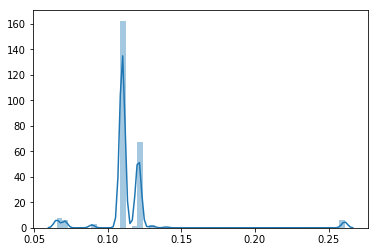

In [42]:
%matplotlib inline
sns.distplot(train_x_responseCoding[:,15])

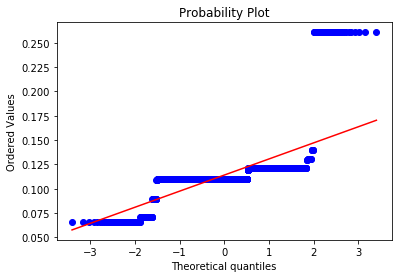

In [40]:
stats.probplot(train_x_responseCoding[:,15], dist="norm", plot=pylab)
pylab.show()

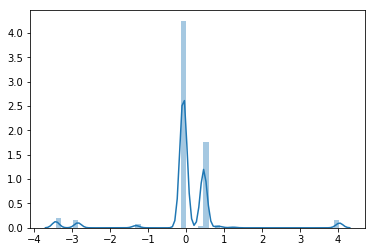

In [43]:
sns.distplot(StandardScaler().fit_transform(np.reshape(boxcox(train_x_responseCoding[:,15])[0], (-1, 1))))

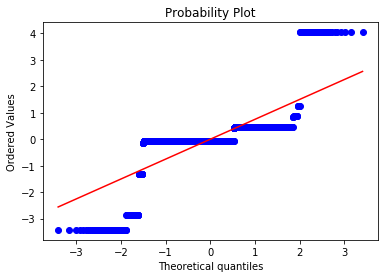

In [44]:
stats.probplot((StandardScaler().fit_transform(np.reshape(boxcox(train_x_responseCoding[:,15])[0], (-1, 1)))).flatten(), dist="norm", plot=pylab)
pylab.show()

Box-cox fails yet again

In [56]:
dtree=DecisionTreeClassifier(max_leaf_nodes=9)
dtree.fit(train_x_responseCoding[:,15:16],y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=9, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

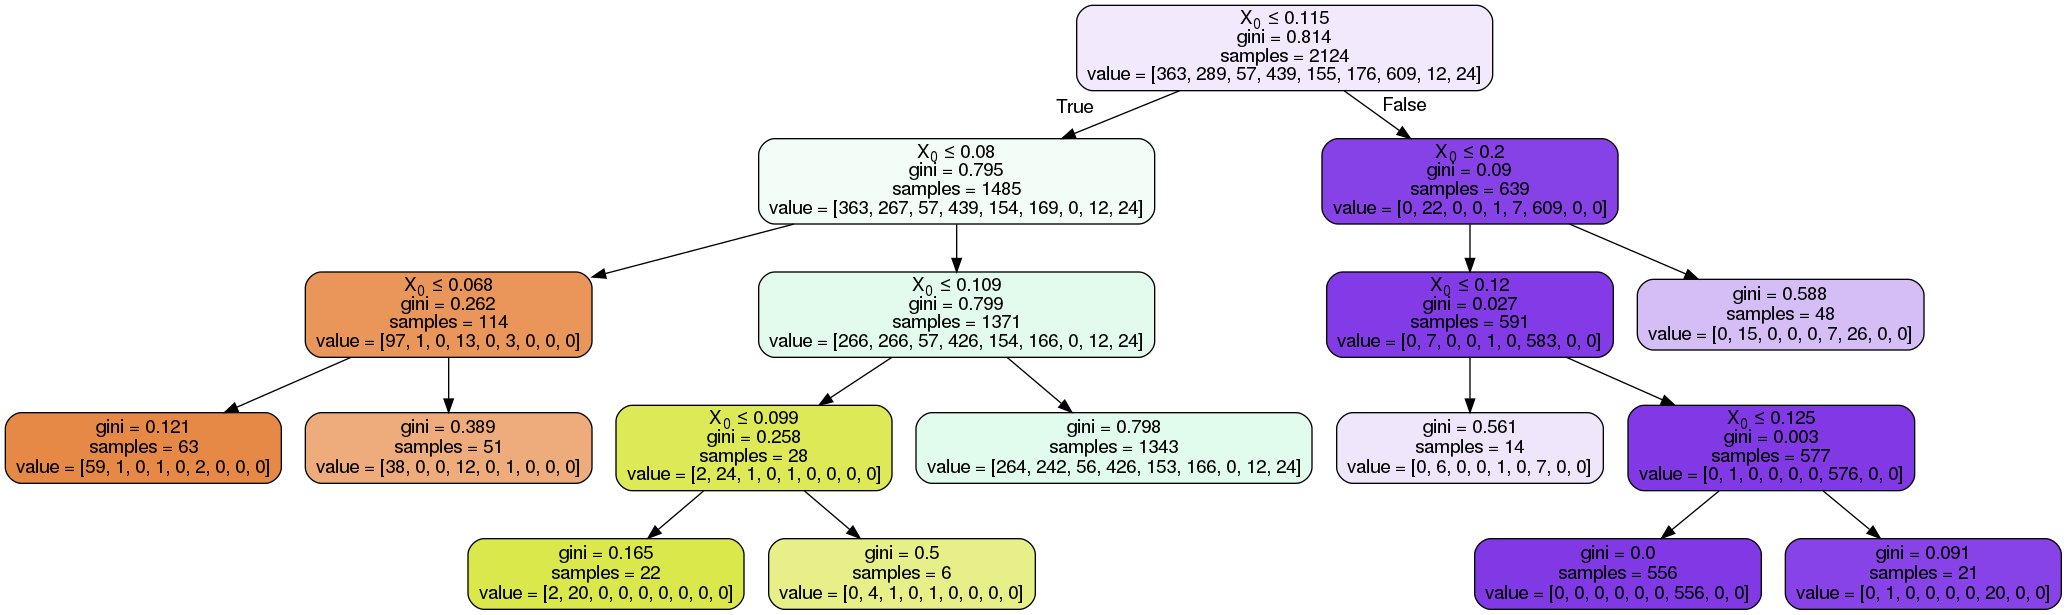

In [57]:
dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [58]:
def bin_func_15(x):
    if x<=0.115:
        if x<=0.08:
            if x<=0.068:
                return 0
            return 1
        if x<=0.109:
            if x<=0.099:
                return 2
            return 3
        return 4
    if x<=0.2:
        if x<=0.12:
            return 5
        if x<=0.125:
            return 6
        return 7
    return 8

In [59]:
feature_15=np.concatenate((train_x_responseCoding[:, 15:16], cv_x_responseCoding[:, 15:16], test_x_responseCoding[:, 15:16]), axis=0)
feature_15=np.reshape(np.apply_along_axis(bin_func_15, 1, feature_15), (-1, 1))

feature_15_train=feature_15[:len(train_x_responseCoding), :]
feature_15_cv=feature_15[len(train_x_responseCoding): len(train_x_responseCoding)+len(cv_x_responseCoding), :]
feature_15_test=feature_15[len(train_x_responseCoding)+len(cv_x_responseCoding) : , :]

In [64]:
train_x_new_features=np.concatenate((feature_15_train, train_x_new_features), axis=1)
cv_x_new_features=np.concatenate((feature_15_cv, cv_x_new_features), axis=1)
test_x_new_features=np.concatenate((feature_15_test, test_x_new_features), axis=1)

for alpha = 1e-07
Log Loss : 1.32162014381
for alpha = 1e-06
Log Loss : 1.3677581432
for alpha = 1e-05
Log Loss : 1.37054740934
for alpha = 0.0001
Log Loss : 1.48499925407
for alpha = 0.001
Log Loss : 1.50755172756
for alpha = 0.01
Log Loss : 1.29207981189
for alpha = 0.1
Log Loss : 1.16783955664
for alpha = 1
Log Loss : 1.44563139419
for alpha = 10
Log Loss : 1.78056209459
for alpha = 100
Log Loss : 1.81061955929
for alpha = 1000
Log Loss : 1.8186673566
for alpha = 10000
Log Loss : 1.8203077321
for alpha = 100000
Log Loss : 1.82080664719


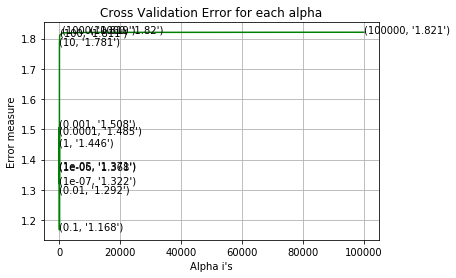

For values of best alpha =  0.1 The train log loss is: 0.774956683845
For values of best alpha =  0.1 The cross validation log loss is: 1.16783955664
For values of best alpha =  0.1 The test log loss is: 1.15848274916


In [65]:
alpha = [10 ** x for x in range(-7, 6)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_new_features[:, :], y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_new_features[:, :], y_train)
    sig_clf_probs = sig_clf.predict_proba(cv_x_new_features[:, :])
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_new_features[:, :], y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_new_features[:, :], y_train)

predict_y = sig_clf.predict_proba(train_x_new_features[:, :])
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_new_features[:, :])
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_new_features[:, :])
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss worsens after including binned feature 15

In [73]:
clf=SGDClassifier(class_weight='balanced', random_state=42, loss='log', alpha=alpha[best_alpha])
clf.fit(train_x_new_features, y_train)

SGDClassifier(alpha=0.01, average=False, class_weight='balanced', epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

Log loss : 1.01856559082
Number of mis-classified points : 0.3609022556390977
-------------------- Confusion matrix --------------------


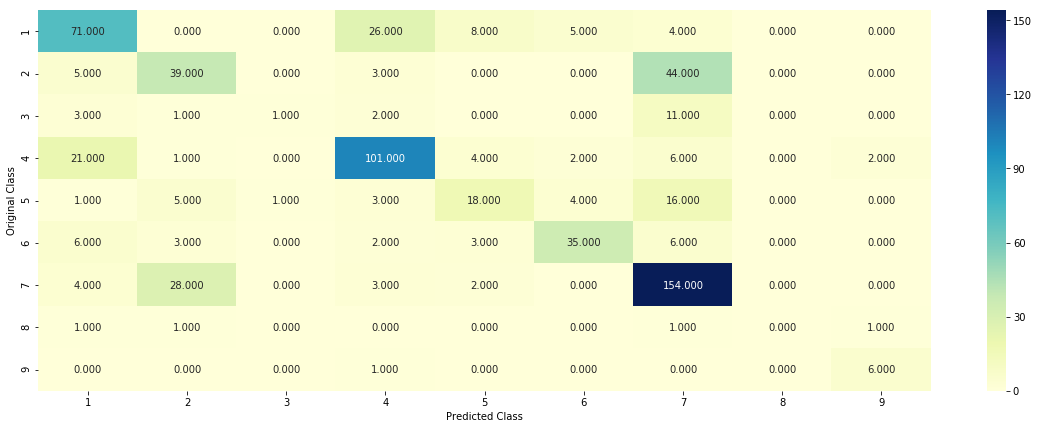

-------------------- Precision matrix (Columm Sum=1) --------------------


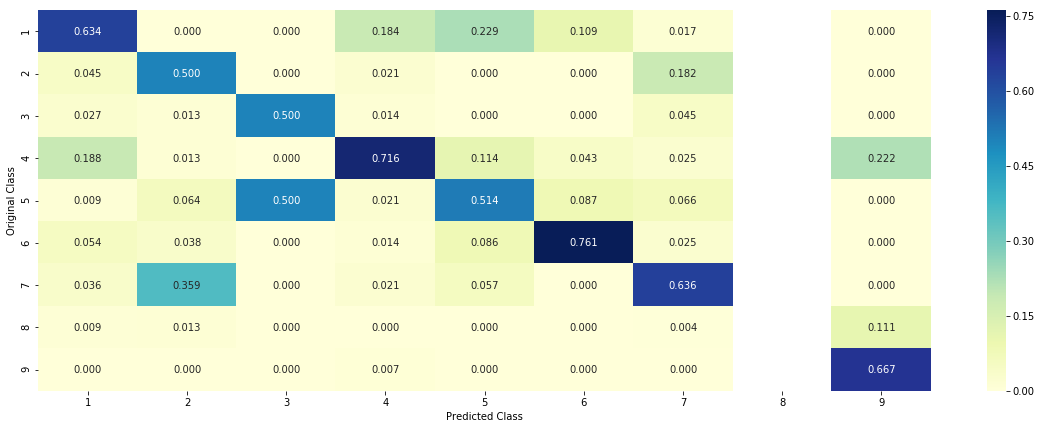

-------------------- Recall matrix (Row sum=1) --------------------


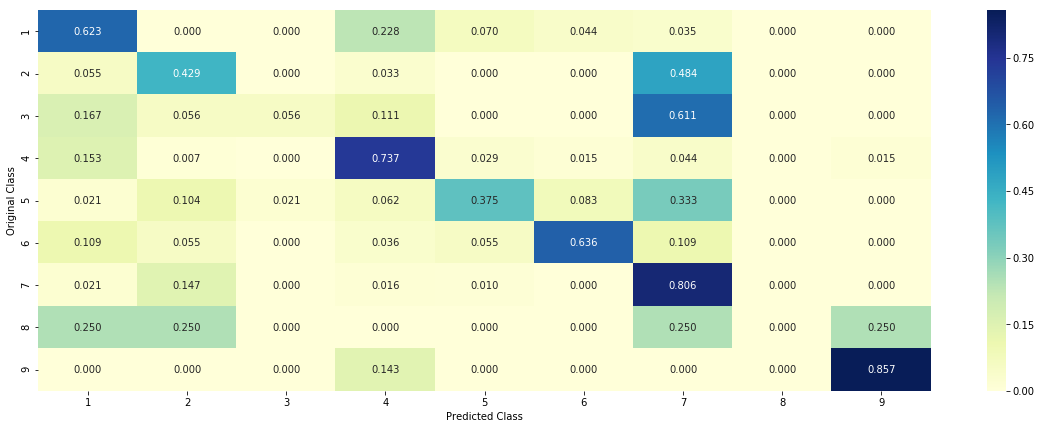

In [74]:
predict_and_plot_confusion_matrix(train_x_new_features, y_train, test_x_new_features, y_test, clf)

## Observation

After feature engineering, even a small subset of transformed features is able to produce results comparable to those obtained obtained on using all features without feature engineering. Train loss in case of engineered features is closer to cross validation and test losses. This sugests reduced overfitting and comparable log loss is obtained after performing small feature engineering.

## Conclusion

In [75]:
results_tfidf=[
    
    ['naive bayes', 0.67, 1.21, 1.16, 38.72],
    ['knn with response coded features', 0.73, 1.00, 1.08, 34.39],
    ['Logistic regression with class balancing', 0.40, 0.97, 0.96, 35.52],
    ['logistic regression with imbalanced classes',0.39, 0.97, 0.96, 35.33],
    ['svm with class balancing', 0.55, 1.07, 1.07, 35.90],
    ['random forest', 0.65, 1.08, 1.06, 37.78],
    ['stacking classifier', 0.41, 1.07, 1.05, 32.93],
    ['voting classifier', 0.53, 1.06, 1.03, 32.48]
    
]

results_tf_idf_top_1000=[
    
    ['naive bayes', 0.53, 1.28, 1.15, 37.14],
    ['Logistic regression with class balancing', 0.45, 1.02, 1.00, 33.27],
    ['svm with class balancing', 0.5, 1.06, 1.06, 34.21],
    ['random forest', 0.55, 1.09, 1.08, 34.58],
    ['stacking classifier', 0.36, 1.06, 1.07, 32.63],
    ['voting classifier', 0.48, 1.04, 1.02, 35.48]
    
]

results_logistic_regression_unigrams_bigrams_class_balancing=[
    
    [0.98, 1.25, 1.24, 41.80]
    
]

results_new_features_logistic_regression=[
    
    [0.79, 1.07, 1.01, 36.09] 
    
]

## TF IDF

In [79]:
pd.DataFrame(results_tfidf, columns=['Classifier name', 'train loss', 'cv loss', 'test loss', '% misclassified'])

,Classifier name,train loss,cv loss,test loss,% misclassified
0,naive bayes,0.67,1.21,1.16,38.72
1,knn with response coded features,0.73,1.00,1.08,34.39
2,Logistic regression with class balancing,0.40,0.97,0.96,35.52
3,logistic regression with imbalanced classes,0.39,0.97,0.96,35.33
4,svm with class balancing,0.55,1.07,1.07,35.90
5,random forest,0.65,1.08,1.06,37.78
6,stacking classifier,0.41,1.07,1.05,32.93
7,voting classifier,0.53,1.06,1.03,32.48


## TF IDF with top 1000 words based on IDF

In [80]:
pd.DataFrame(results_tf_idf_top_1000, columns=['Classifier name', 'train loss', 'cv loss', 'test loss', '% misclassified'])

,Classifier name,train loss,cv loss,test loss,% misclassified
0,naive bayes,0.53,1.28,1.15,37.14
1,Logistic regression with class balancing,0.45,1.02,1.00,33.27
2,svm with class balancing,0.50,1.06,1.06,34.21
3,random forest,0.55,1.09,1.08,34.58
4,stacking classifier,0.36,1.06,1.07,32.63
5,voting classifier,0.48,1.04,1.02,35.48


## LR with both unigrams and bigrams

In [81]:
pd.DataFrame(results_logistic_regression_unigrams_bigrams_class_balancing, columns=['train loss', 'cv loss', 'test loss', '% misclassified'])

,train loss,cv loss,test loss,% misclassified
0,0.98,1.25,1.24,41.8


## LR with new features

In [82]:
pd.DataFrame(results_new_features_logistic_regression, columns=['train loss', 'cv loss', 'test loss', '% misclassified'])

,train loss,cv loss,test loss,% misclassified
0,0.79,1.07,1.01,36.09
